# Prevendo notas matemática com Python


As notas se apresentam como variáveis importantes para prever a nota de matemática, sem falar que existem vários valores ausentes nelas e também muitos ausentes na coluna alvo (nota mat).

Antes começar manusear os missings e testar um modelo de regressão (random forest ou SVM), podemos usar algum modelo simples e robusto para preencher os missings das notas, pois temos o ID da prova (CO_PROVA_CH), o gabarito e a resposta do aluno, assim sendo simples determinar sua pontuação.

Tods as colunas *TX_* vão cair fora pois se tratam de respostas e gabaritos com missings colineares com outras colunas de bastante missings (aparecem juntos), além de que elas não aparecem no teste.

In [1]:
# bibliotecas
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from fancyimpute import KNN, IterativeImputer, SoftImpute
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
# mostrar todas as colunas e informação na saída do prompt (head ou info)
pd.set_option('display.max_columns', None)
%matplotlib inline

Using TensorFlow backend.


In [2]:
# lendo dados
treino = pd.read_csv('train.csv', index_col=0)
teste = pd.read_csv('test.csv', index_col=0)

In [3]:
treino.head()

NU_INSCRICAO  NU_ANO  CO_MUNICIPIO_RESIDENCIA  \
1  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad    2016                  4314902   
2  2c3acac4b33ec2b195d77e7c04a2d75727fad723    2016                  2304707   
3  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568    2016                  2304400   
4  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe    2016                  3304557   
5  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268    2016                  1302603   

  NO_MUNICIPIO_RESIDENCIA  CO_UF_RESIDENCIA SG_UF_RESIDENCIA  NU_IDADE  \
1            Porto Alegre                43               RS        24   
2                  Granja                23               CE        17   
3               Fortaleza                23               CE        21   
4          Rio de Janeiro                33               RJ        25   
5                  Manaus                13               AM        28   

  TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  TP_NACIONALIDADE  \
1       M              0.0            1                 1   
2       F              0.0            3                 1   
3       F              0.0            3                 1   
4       F              0.0            0                 1   
5       M              0.0            2                 1   

   CO_MUNICIPIO_NASCIMENTO NO_MUNICIPIO_NASCIMENTO  CO_UF_NASCIMENTO  \
1                4314902.0            Porto Alegre              43.0   
2                2304707.0                  Granja              23.0   
3                2304400.0               Fortaleza              23.0   
4                3304557.0          Rio de Janeiro              33.0   
5                1505304.0               Oriximiná              15.0   

  SG_UF_NASCIMENTO  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  TP_ENSINO  \
1               RS                1                4          1        NaN   
2               CE                2                0          2        1.0   
3               CE                3                0          1        NaN   
4               RJ                1                9          1        NaN   
5               PA                1                4          1        NaN   

   IN_TREINEIRO   CO_ESCOLA  CO_MUNICIPIO_ESC NO_MUNICIPIO_ESC  CO_UF_ESC  \
1             0         NaN               NaN              NaN        NaN   
2             0  23005157.0         2304707.0           Granja       23.0   
3             0         NaN               NaN              NaN        NaN   
4             0         NaN               NaN              NaN        NaN   
5             0         NaN               NaN              NaN        NaN   

  SG_UF_ESC  TP_DEPENDENCIA_ADM_ESC  TP_LOCALIZACAO_ESC  TP_SIT_FUNC_ESC  \
1       NaN                     NaN                 NaN              NaN   
2        CE                     2.0                 1.0              1.0   
3       NaN                     NaN                 NaN              NaN   
4       NaN                     NaN                 NaN              NaN   
5       NaN                     NaN                 NaN              NaN   

   IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DEFICIENCIA_AUDITIVA  \
1               0            0          0                        0   
2               0            0          0                        0   
3               0            0          0                        0   
4               0            0          0                        0   
5               0            0          0                        0   

   IN_SURDO_CEGUEIRA  IN_DEFICIENCIA_FISICA  IN_DEFICIENCIA_MENTAL  \
1                  0                      0                      0   
2                  0                      0                      0   
3                  0                      0                      0   
4                  0                      0                      0   
5                  0                      0                      0   

   IN_DEFICIT_ATENCAO  IN_DISLEXIA  IN_DISCALCULIA  IN_AUTISMO  \
1       

In [4]:
teste.head()

CO_UF_RESIDENCIA SG_UF_RESIDENCIA  \
NU_INSCRICAO                                                                  
73ff9fcc02f0a99919906c942c2e1a1042cdcf98                41               PR   
71a95f9f1b91a82c65ad94abbdf9f54e6066f968                21               MA   
b38a03232f43b11c9d0788abaf060f7366053b6d                23               CE   
70b682d9a3636be23f6120fa9d6b164eb3c6002d                15               PA   
715494628a50142ce8cb17191cfe6d0f3cae0934                41               PR   

                                          NU_IDADE TP_SEXO  TP_COR_RACA  \
NU_INSCRICAO                                                              
73ff9fcc02f0a99919906c942c2e1a1042cdcf98        22       F            3   
71a95f9f1b91a82c65ad94abbdf9f54e6066f968        26       F            3   
b38a03232f43b11c9d0788abaf060f7366053b6d        21       M            1   
70b682d9a3636be23f6120fa9d6b164eb3c6002d        27       F            3   
715494628a50142ce8cb17191cfe6d0f3cae0934        18       M            1   

                                          TP_NACIONALIDADE  TP_ST_CONCLUSAO  \
NU_INSCRICAO                                                                  
73ff9fcc02f0a99919906c942c2e1a1042cdcf98                 1                1   
71a95f9f1b91a82c65ad94abbdf9f54e6066f968                 1                1   
b38a03232f43b11c9d0788abaf060f7366053b6d                 1                2   
70b682d9a3636be23f6120fa9d6b164eb3c6002d                 1                1   
715494628a50142ce8cb17191cfe6d0f3cae0934                 1                2   

                                          TP_ANO_CONCLUIU  TP_ESCOLA  \
NU_INSCRICAO                                                           
73ff9fcc02f0a99919906c942c2e1a1042cdcf98                5          1   
71a95f9f1b91a82c65ad94abbdf9f54e6066f968                8          1   
b38a03232f43b11c9d0788abaf060f7366053b6d                0          2   
70b682d9a3636be23f6120fa9d6b164eb3c6002d                8          1   
715494628a50142ce8cb17191cfe6d0f3cae0934                0          2   

                                          TP_ENSINO  IN_TREINEIRO  \
NU_INSCRICAO                                                        
73ff9fcc02f0a99919906c942c2e1a1042cdcf98        NaN             0   
71a95f9f1b91a82c65ad94abbdf9f54e6066f968        NaN             0   
b38a03232f43b11c9d0788abaf060f7366053b6d        3.0             0   
70b682d9a3636be23f6120fa9d6b164eb3c6002d        NaN             0   
715494628a50142ce8cb17191cfe6d0f3cae0934        1.0             0   

                                          TP_DEPENDENCIA_ADM_ESC  \
NU_INSCRICAO                                                       
73ff9fcc02f0a99919906c942c2e1a1042cdcf98                     NaN   
71a95f9f1b91a82c65ad94abbdf9f54e6066f968                     NaN   
b38a03232f43b11c9d0788abaf060f7366053b6d                     2.0   
70b682d9a3636be23f6120fa9d6b164eb3c6002d                     NaN   
715494628a50142ce8cb17191cfe6d0f3cae0934                     2.0   

                                          IN_BAIXA_VISAO  IN_CEGUEIRA  \
NU_INSCRICAO                                                            
73ff9fcc02f0a99919906c942c2e1a1042cdcf98               0            0   
71a95f9f1b91a82c65ad94abbdf9f54e6066f968               0            0   
b38a03232f43b11c9d0788abaf060f7366053b6d               0            0   
70b682d9a3636be23f6120fa9d6b164eb3c6002d               0            0   
715494628a50142ce8cb17191cfe6d0f3cae0934               0            0   

                                          IN_SURDEZ  IN_DISLEXIA  \
NU_INSCRICAO                                                       
73ff9fcc02f0a99919906c942c2e1a1042cdcf98          0            0   
71a95f9f1b91a82c65ad94abbdf9f54e6066f968          0            0   
b38a03232f43b11c9d0788abaf060f7366053b6d          0            0   
70b682d9a3636be23f6120fa9d6b164eb3c6002d          0            0   
715494628a50142ce8cb17

In [5]:
print('dimTreino', treino.shape, '\ndimTeste', teste.shape)

dimTreino (13730, 166) 
dimTeste (4576, 46)


Algumas colunas devem ser removidas, pois havia duplicidade de informação (código do estado e sigla do estado, por exemplo).

In [6]:
colsRemov = [
    # removendo ID do candidato (alta cardinalidade)
    'NU_INSCRICAO',
    'NU_ANO',
    # tiram ID de nome, deixando os CODIGO
    'NO_MUNICIPIO_RESIDENCIA',
    # esse preciso deixar pois existe conjunto TESTE
    #'SG_UF_RESIDENCIA',
    # então retiro o código
    'CO_UF_RESIDENCIA',
    'NO_MUNICIPIO_NASCIMENTO',
    'SG_UF_NASCIMENTO',
    # informação de localização já existe no municipio
    'CO_ESCOLA',
    'CO_MUNICIPIO_ESC',
    'NO_MUNICIPIO_ESC',
    'CO_UF_ESC',
    'SG_UF_ESC',
    # aparentemente informação irrelevante
    'NO_ENTIDADE_CERTIFICACAO',
    'NO_MUNICIPIO_PROVA',
    'SG_UF_PROVA',
    # removendo respostas e gabarito
    'TX_RESPOSTAS_CN',
    'TX_RESPOSTAS_CH',
    'TX_RESPOSTAS_LC',               
    'TX_RESPOSTAS_MT',               
    'TX_GABARITO_CN',                
    'TX_GABARITO_CH',                
    'TX_GABARITO_LC',                
    'TX_GABARITO_MT',        
    # colunas com alta cardinalidade (muitos items)
    # identificacao das cidades
    'CO_MUNICIPIO_RESIDENCIA', 
    'CO_MUNICIPIO_NASCIMENTO', 
    'CO_MUNICIPIO_PROVA',
    # informação redundantes pois já tenho o estado onde de residência
    'CO_UF_NASCIMENTO',
    'CO_UF_PROVA'
]    

In [7]:
treino.shape

(13730, 166)

In [8]:
# removendo colunas do treino
treino.drop(colsRemov, axis=1, inplace=True)
treino.shape

(13730, 139)

In [9]:
teste.shape

(4576, 46)

In [10]:
# removendo essas colunas do teste (caso estejam presentes)
for coluna in list(teste.columns):
    if coluna in colsRemov:
        teste.drop(coluna, axis=1, inplace=True)
        
teste.shape

(4576, 45)

In [11]:
treino.head()

SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  \
1               RS        24       M              0.0            1   
2               CE        17       F              0.0            3   
3               CE        21       F              0.0            3   
4               RJ        25       F              0.0            0   
5               AM        28       M              0.0            2   

   TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  TP_ENSINO  \
1                 1                1                4          1        NaN   
2                 1                2                0          2        1.0   
3                 1                3                0          1        NaN   
4                 1                1                9          1        NaN   
5                 1                1                4          1        NaN   

   IN_TREINEIRO  TP_DEPENDENCIA_ADM_ESC  TP_LOCALIZACAO_ESC  TP_SIT_FUNC_ESC  \
1             0                     NaN                 NaN              NaN   
2             0                     2.0                 1.0              1.0   
3             0                     NaN                 NaN              NaN   
4             0                     NaN                 NaN              NaN   
5             0                     NaN                 NaN              NaN   

   IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DEFICIENCIA_AUDITIVA  \
1               0            0          0                        0   
2               0            0          0                        0   
3               0            0          0                        0   
4               0            0          0                        0   
5               0            0          0                        0   

   IN_SURDO_CEGUEIRA  IN_DEFICIENCIA_FISICA  IN_DEFICIENCIA_MENTAL  \
1                  0                      0                      0   
2                  0                      0                      0   
3                  0                      0                      0   
4                  0                      0                      0   
5                  0                      0                      0   

   IN_DEFICIT_ATENCAO  IN_DISLEXIA  IN_DISCALCULIA  IN_AUTISMO  \
1                   0            0               0           0   
2                   0            0               0           0   
3                   0            0               0           0   
4                   0            0               0           0   
5                   0            0               0           0   

   IN_VISAO_MONOCULAR  IN_OUTRA_DEF  IN_SABATISTA  IN_GESTANTE  IN_LACTANTE  \
1                   0             0             0            0            0   
2                   0             0             0            0            0   
3                   0             0             0            0            0   
4                   0             0             0            0            0   
5                   0             0             0            0            0   

   IN_IDOSO  IN_ESTUDA_CLASSE_HOSPITALAR  IN_SEM_RECURSO  IN_BRAILLE  \
1         0                            0               0           0   
2         0                            0               0           0   
3         0                            0               0           0   
4         0                            0               0           0   
5         0                            0               0           0   

   IN_AMPLIADA_24  IN_AMPLIADA_18  IN_LEDOR  IN_ACESSO  IN_TRANSCRICAO  \
1               0               0         0          0               0   
2               0               0         0          0               0   
3               0               0         0          0               0   
4               0               0         0          0               0   
5               0               0         0          0               0   

   IN_LIBRAS  IN_LEITURA_LABIAL  

In [12]:
treino.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13730 entries, 1 to 4586
Data columns (total 139 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   SG_UF_RESIDENCIA             object 
 1   NU_IDADE                     int64  
 2   TP_SEXO                      object 
 3   TP_ESTADO_CIVIL              float64
 4   TP_COR_RACA                  int64  
 5   TP_NACIONALIDADE             int64  
 6   TP_ST_CONCLUSAO              int64  
 7   TP_ANO_CONCLUIU              int64  
 8   TP_ESCOLA                    int64  
 9   TP_ENSINO                    float64
 10  IN_TREINEIRO                 int64  
 11  TP_DEPENDENCIA_ADM_ESC       float64
 12  TP_LOCALIZACAO_ESC           float64
 13  TP_SIT_FUNC_ESC              float64
 14  IN_BAIXA_VISAO               int64  
 15  IN_CEGUEIRA                  int64  
 16  IN_SURDEZ                    int64  
 17  IN_DEFICIENCIA_AUDITIVA      int64  
 18  IN_SURDO_CEGUEIRA            int64  
 19  IN_D

In [13]:
pd.set_option('display.expand_frame_repr', False)

## Checando a porcentagem de missings (valores ausentes)

In [14]:
def porcentNA(df, nomeDf):
    # calcula e printa a porcentagem de valores ausentes
    # em cada coluna do DF
    # retorna a tabela com os percentuais
    
    # calcula porcentagem de missings
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    percentualMiss = df.isnull().sum() * 100 / len(df)

    # mostra porcentagem de MISSINGS
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        print(nomeDf+' - PORCENTAGEM de NA em cada COLUNA'+'\n\n',percentualMiss)
    
    return percentualMiss

In [15]:
naTreinoDf = porcentNA(treino, 'Treino')

Treino - PORCENTAGEM de NA em cada COLUNA

 SG_UF_RESIDENCIA                0.000000
NU_IDADE                        0.000000
TP_SEXO                         0.000000
TP_ESTADO_CIVIL                 3.845594
TP_COR_RACA                     0.000000
TP_NACIONALIDADE                0.000000
TP_ST_CONCLUSAO                 0.000000
TP_ANO_CONCLUIU                 0.000000
TP_ESCOLA                       0.000000
TP_ENSINO                      68.812819
IN_TREINEIRO                    0.000000
TP_DEPENDENCIA_ADM_ESC         68.812819
TP_LOCALIZACAO_ESC             68.812819
TP_SIT_FUNC_ESC                68.812819
IN_BAIXA_VISAO                  0.000000
IN_CEGUEIRA                     0.000000
IN_SURDEZ                       0.000000
IN_DEFICIENCIA_AUDITIVA         0.000000
IN_SURDO_CEGUEIRA               0.000000
IN_DEFICIENCIA_FISICA           0.000000
IN_DEFICIENCIA_MENTAL           0.000000
IN_DEFICIT_ATENCAO              0.000000
IN_DISLEXIA                     0.000000
IN_DISCALCULI

In [16]:
naTesteDf = porcentNA(teste, "Teste")

Teste - PORCENTAGEM de NA em cada COLUNA

 SG_UF_RESIDENCIA           0.000000
NU_IDADE                   0.000000
TP_SEXO                    0.000000
TP_COR_RACA                0.000000
TP_NACIONALIDADE           0.000000
TP_ST_CONCLUSAO            0.000000
TP_ANO_CONCLUIU            0.000000
TP_ESCOLA                  0.000000
TP_ENSINO                 67.657343
IN_TREINEIRO               0.000000
TP_DEPENDENCIA_ADM_ESC    67.657343
IN_BAIXA_VISAO             0.000000
IN_CEGUEIRA                0.000000
IN_SURDEZ                  0.000000
IN_DISLEXIA                0.000000
IN_DISCALCULIA             0.000000
IN_SABATISTA               0.000000
IN_GESTANTE                0.000000
IN_IDOSO                   0.000000
TP_PRESENCA_CN             0.000000
TP_PRESENCA_CH             0.000000
TP_PRESENCA_LC             0.000000
CO_PROVA_CN                0.000000
CO_PROVA_CH                0.000000
CO_PROVA_LC                0.000000
CO_PROVA_MT                0.000000
NU_NOTA_CN           

Vamos remover as colunas com mais de 50% dos missings
O *TP_DEPENDENCIA_ADM_ESC* (estadual, privada, federal) e *Q027* (quantos anos começou trabalhar) apesar de muitos NAs (68% e 53%) serão poupados por aparecerem no teste e serem features relevantes.                       

In [17]:
colsPoupar = ['TP_DEPENDENCIA_ADM_ESC', 'Q027']

In [18]:
# selcionar naTreinoDf < 50 or index in ['TP_DEPENDENCIA_ADM_ESC', 'Q027']

# montando vetores logicos para manter essas colunas
pouparTreino = np.zeros(len(naTreinoDf))
pouparTeste = np.zeros(len(naTesteDf))

for col in colsPoupar:
    pouparTreino[(list(naTreinoDf.index)).index(col)] = 1
    pouparTeste[(list(naTesteDf.index)).index(col)] = 1
    
for i in np.arange(len(naTreinoDf)):
    pouparTreino[i] = (naTreinoDf < 50)[i] or pouparTreino[i]
    
for i in np.arange(len(naTesteDf)):
    pouparTeste[i] = (naTesteDf < 50)[i] or pouparTeste[i]
    
# convertendo para booleano
pouparTreino = pouparTreino.astype(bool)
pouparTeste = pouparTeste.astype(bool)

In [19]:
pouparTeste

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [20]:
print(treino.shape, teste.shape)

(13730, 139) (4576, 45)


In [21]:
naTreinoDf = naTreinoDf.loc[pouparTreino]
naTesteDf = naTesteDf.loc[pouparTeste]

In [22]:
treino = treino[list(naTreinoDf.index)]
teste = teste[list(naTesteDf.index)]

In [23]:
print(treino.shape, teste.shape)

(13730, 127) (4576, 44)


In [24]:
treino.head()

SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  IN_TREINEIRO  TP_DEPENDENCIA_ADM_ESC  IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DEFICIENCIA_AUDITIVA  IN_SURDO_CEGUEIRA  IN_DEFICIENCIA_FISICA  IN_DEFICIENCIA_MENTAL  IN_DEFICIT_ATENCAO  IN_DISLEXIA  IN_DISCALCULIA  IN_AUTISMO  IN_VISAO_MONOCULAR  IN_OUTRA_DEF  IN_SABATISTA  IN_GESTANTE  IN_LACTANTE  IN_IDOSO  IN_ESTUDA_CLASSE_HOSPITALAR  IN_SEM_RECURSO  IN_BRAILLE  IN_AMPLIADA_24  IN_AMPLIADA_18  IN_LEDOR  IN_ACESSO  IN_TRANSCRICAO  IN_LIBRAS  IN_LEITURA_LABIAL  IN_MESA_CADEIRA_RODAS  IN_MESA_CADEIRA_SEPARADA  IN_APOIO_PERNA  IN_GUIA_INTERPRETE  IN_MACA  IN_COMPUTADOR  IN_CADEIRA_ESPECIAL  IN_CADEIRA_CANHOTO  IN_CADEIRA_ACOLCHOADA  IN_PROVA_DEITADO  IN_MOBILIARIO_OBESO  IN_LAMINA_OVERLAY  IN_PROTETOR_AURICULAR  IN_MEDIDOR_GLICOSE  IN_MAQUINA_BRAILE  IN_SOROBAN  IN_MARCA_PASSO  IN_SONDA  IN_MEDICAMENTOS  IN_SALA_INDIVIDUAL  IN_SALA_ESPECIAL  IN_SALA_ACOMPANHANTE  IN_MOBILIARIO_ESPECIFICO  IN_MATERIAL_ESPECIFICO  IN_NOME_SOCIAL  IN_CERTIFICADO  TP_PRESENCA_CN  TP_PRESENCA_CH  TP_PRESENCA_LC  TP_PRESENCA_MT                               CO_PROVA_CN                               CO_PROVA_CH                               CO_PROVA_LC                               CO_PROVA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  NU_NOTA_MT  TP_LINGUA  TP_STATUS_REDACAO  NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  NU_NOTA_COMP5  NU_NOTA_REDACAO Q001 Q002 Q003 Q004  Q005 Q006 Q007 Q008 Q009 Q010 Q011 Q012 Q013 Q014 Q015 Q016 Q017 Q018 Q019 Q020 Q021 Q022 Q023 Q024 Q025 Q026 Q027  Q034  Q035  Q036  Q037  Q038  Q039  Q040 Q042 Q043 Q044 Q045 Q046 Q047 Q048 Q049 Q050
1               RS        24       M              0.0            1                 1                1                4          1             0                     NaN               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0             0            0            0         0                            0               0           0               0               0         0          0               0          0                  0                      0                         0               0                   0        0              0                    0                   0                      0                 0                    0                  0                      0                   0                  0           0               0         0                0                   0                 0                     0                         0                       0               0               0               1               1               1               1  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8  01af53cd161a420fff1767129c10de560cc264dd  97caab1e1533dba217deb7ef41490f52e459ab01       436.3       495.4       581.2       399.4          1                1.0          120.0          120.0          120.0           80.0           80.0            520.0    D    D    B    B     3    C    A    B    B    B    A    B    A    A    A    A    A    A    B    A    A    C    A    A    A    C    H     5     5     0     5     5     5     5    A    A    A    A    A    A    A    B    D
2               CE        17       F              0.0            3                 1                2                0          2             0                     2.0               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0             0            0            0         0                            0               0           0               0               0         0          0               0      

## Visualizando os missings

Na questão de usar o gabarito e as respostas do alunos para prever notas ausentes, caso esses valores ausentes apareçam juntos de nada adianta, então as colunas dos gabaritos podem ser excluidas.

Vamos visualizar a correlação dos missings.

In [25]:
# paleta de cores
default_color = '#56B4E9'
colormap = plt.cm.cool
#plt.style.use('dark_background')
plt.style.use('classic')

In [26]:
# pegandos apenas missings
missingValueColumns = treino.columns[treino.isnull().any()].tolist()
nuloDf = treino[missingValueColumns] 

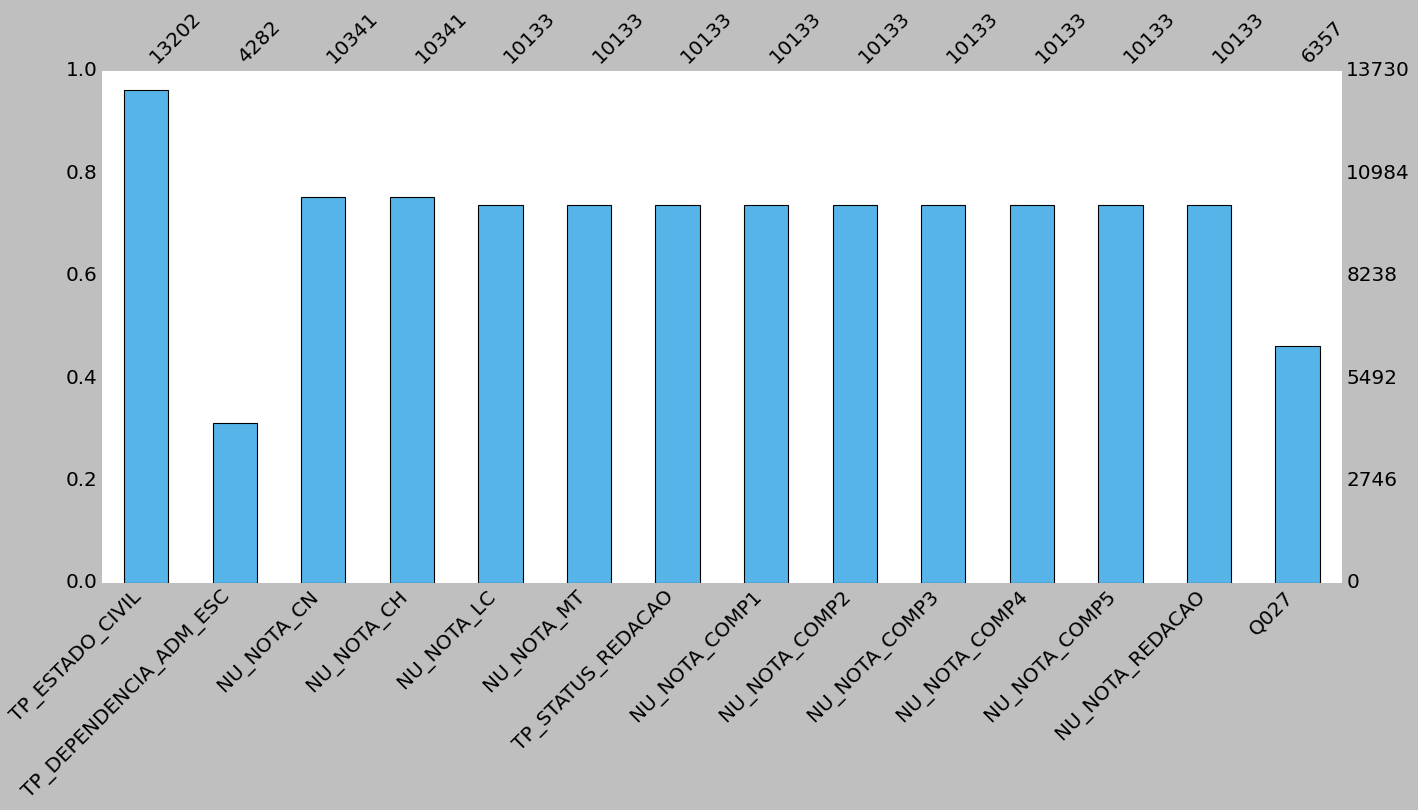

In [27]:
msno.bar(nuloDf,figsize=(20,8),color=default_color,fontsize=18,labels=True)

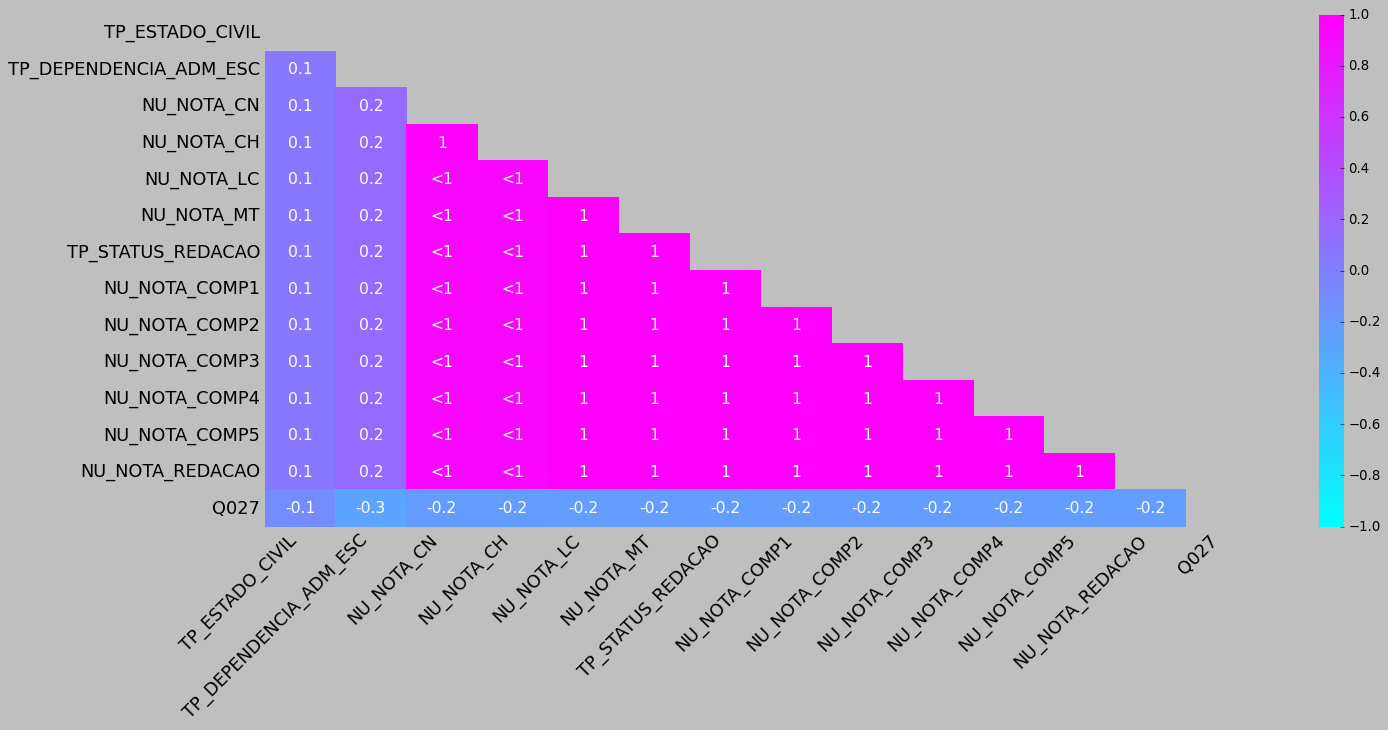

In [28]:
msno.heatmap(nuloDf, figsize=(20,8), cmap=colormap)

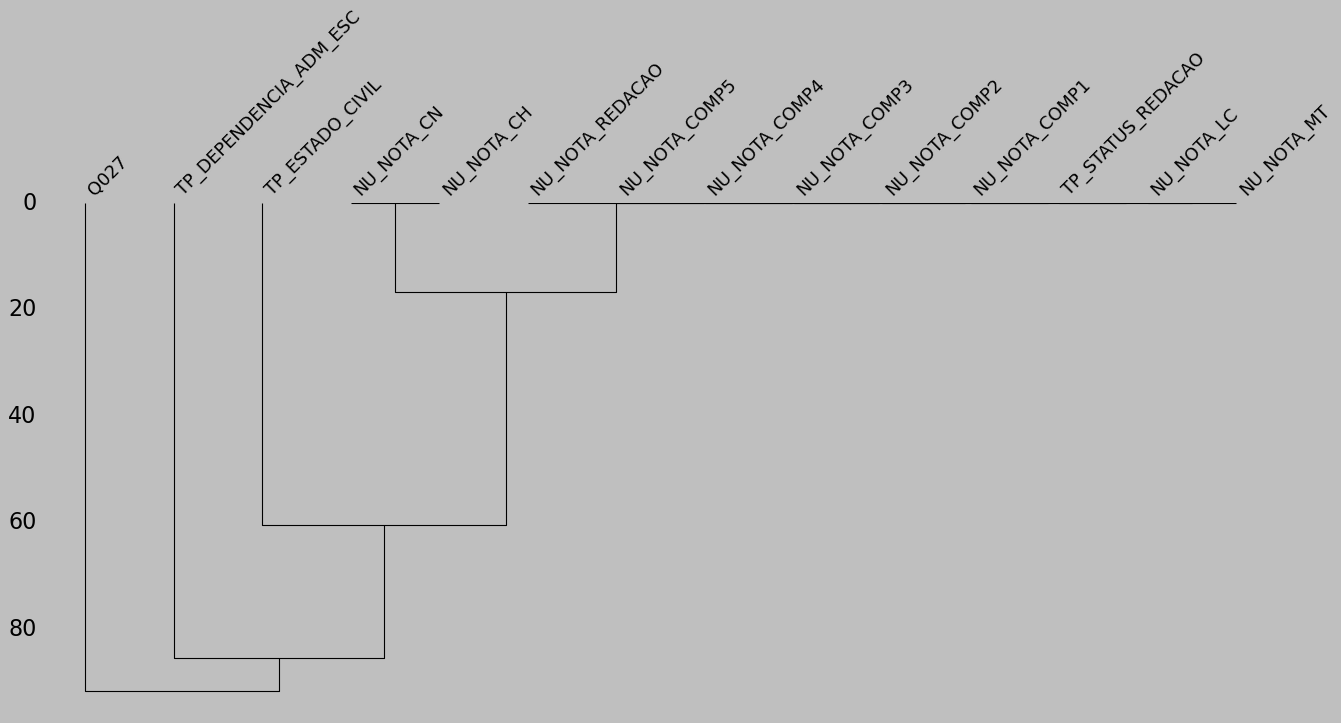

In [29]:
msno.dendrogram(nuloDf,figsize=(20,8))

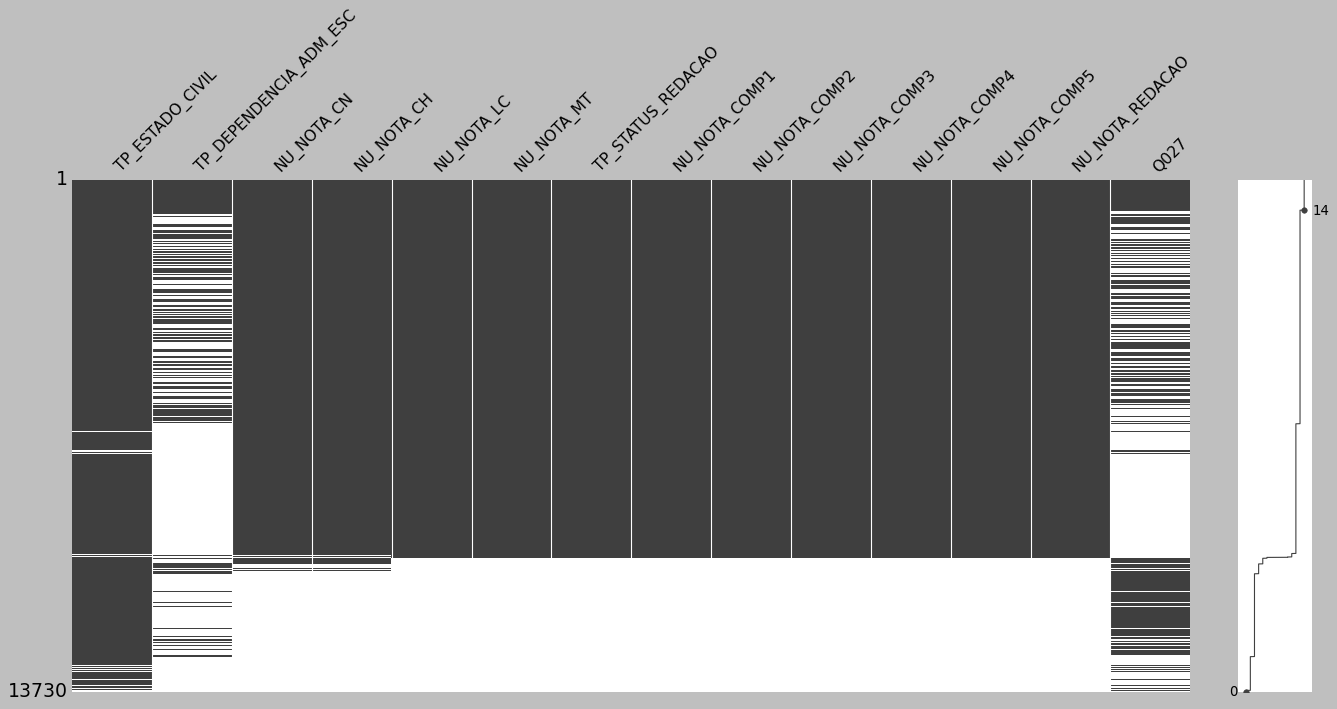

In [30]:
sorted_data = msno.nullity_sort(nuloDf, sort='descending') # or sort='ascending'
msno.matrix(sorted_data,figsize=(20,8),fontsize=14)

Acima vemos que os valores fantants caminham juntos e representam em torno de 25% dos dados.

Dessa podemos tentar removê-los ou preenchê-los.

## Visualizando o Alvo

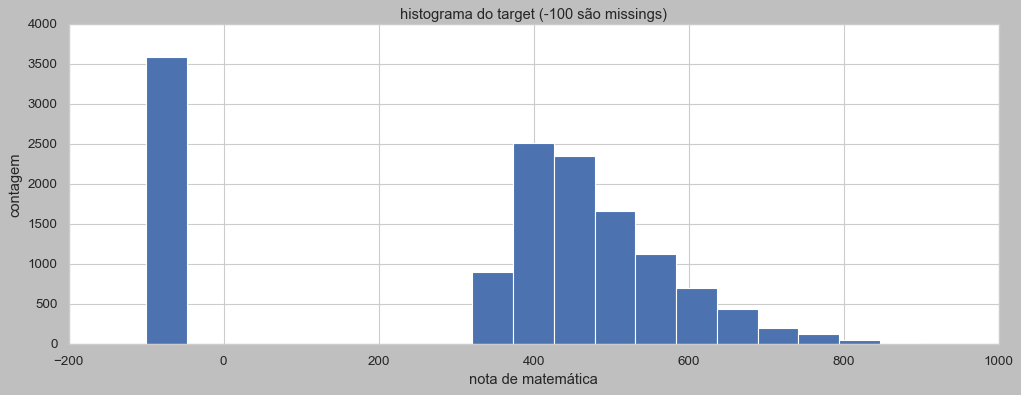

In [31]:
# auxiliar para enchegar missings
aux = treino.copy()
aux = aux.fillna(-100)

plt.figure(figsize=(15,5))
plt.style.use('dark_background')

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

sns.distplot(
    aux['NU_NOTA_MT'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='nota de matemática', ylabel='contagem', title='histograma do target (-100 são missings)');

# deletando auxiliar
del aux

## Relação das variáveis contínuas

In [32]:
# variaveis numericas continuas
numContin = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT']

# variaveis numericas inteiras
numDisc = ['NU_IDADE','NU_NOTA_COMP1','NU_NOTA_COMP2','NU_NOTA_COMP3','NU_NOTA_COMP4','NU_NOTA_COMP5','NU_NOTA_REDACAO']

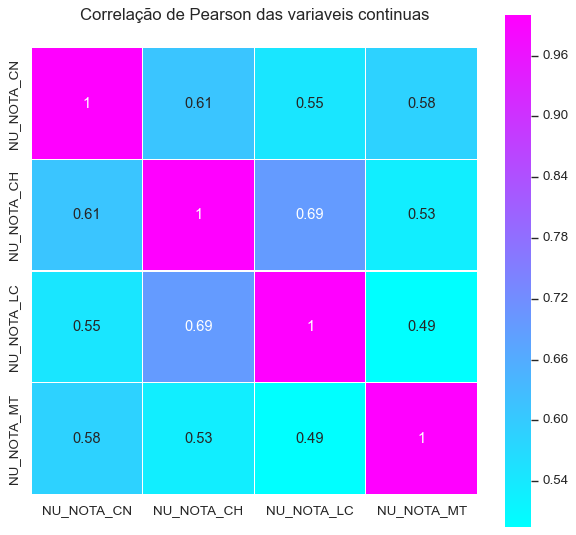

In [33]:
plt.figure(figsize=(18*.5,16*.5))
plt.title('Correlação de Pearson das variaveis continuas', y=1.05, size=15)
sns.heatmap(treino[numContin].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

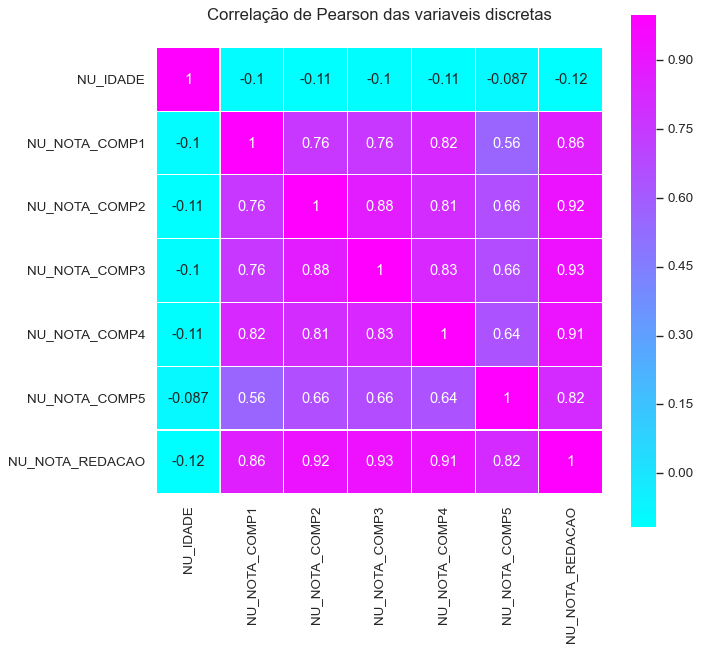

In [34]:
# esse grafico não faz sentidos (pois são numeros inteira)
# mas vamos visualizar por curiosidade hehe
plt.figure(figsize=(18*.5,16*.5))
plt.title('Correlação de Pearson das variaveis discretas', y=1.05, size=15)
sns.heatmap(treino[numDisc].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# Limpando os dados

## Tipos das variáveis

* numérica discreta (idade, notas inteiras)
* numérica contínua (notas quebradas)
* categóricas nominais / dummies (estado, cidade, tipo escola)
* categóricas ordinais (renda, qualificação dos pais)
* categóricas binárias (sexo, sim/não)

In [35]:
def tiposVariaveis(df):
    # recebe p DF
    # retorna dicionario o nomes das variaveis na ordem
    # numDisc, numCont, categNom, categOrd, categBin
    numDisc = []
    numCont = []
    # binárias vão entrar em nominal
    categNom = []
    categOrd = []
    categBin = []

    # classificando as colunas de acordo com o tipo delas
    for col in df.columns:

        if 'Q0' in col:
            if col in ['Q018','Q020','Q021','Q023','Q025']:
                categBin.append(col)
            else:
                categOrd.append(col)

        if any(list(map(lambda x: x in col, ['IN_','CO_','SG_','TP_','TX_']))):
            if any(list(map(lambda x: x in col, ['IN_','TP_SEXO','TP_LINGUA']))):
                categBin.append(col)
            else:
                categNom.append(col)

        if col in 'NU_IDADE':
            numDisc.append(col)


        if 'NU_NOTA_' in col:
            if any(list(map(lambda x: x in col, ['NU_NOTA_COMP','NU_NOTA_REDACAO']))):
                numDisc.append(col)
            else:
                numCont.append(col)

    return {'numDisc':numDisc, 'numCont':numCont,
            'categNom':categNom, 'categOrd':categOrd, 'categBin':categBin}

In [36]:
colsTreino = tiposVariaveis(treino)
colsTeste = tiposVariaveis(teste)

In [37]:
colsTreino

{'numDisc': ['NU_IDADE',
  'NU_NOTA_COMP1',
  'NU_NOTA_COMP2',
  'NU_NOTA_COMP3',
  'NU_NOTA_COMP4',
  'NU_NOTA_COMP5',
  'NU_NOTA_REDACAO'],
 'numCont': ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT'],
 'categNom': ['SG_UF_RESIDENCIA',
  'TP_ESTADO_CIVIL',
  'TP_COR_RACA',
  'TP_NACIONALIDADE',
  'TP_ST_CONCLUSAO',
  'TP_ANO_CONCLUIU',
  'TP_ESCOLA',
  'TP_DEPENDENCIA_ADM_ESC',
  'TP_PRESENCA_CN',
  'TP_PRESENCA_CH',
  'TP_PRESENCA_LC',
  'TP_PRESENCA_MT',
  'CO_PROVA_CN',
  'CO_PROVA_CH',
  'CO_PROVA_LC',
  'CO_PROVA_MT',
  'TP_STATUS_REDACAO'],
 'categOrd': ['Q001',
  'Q002',
  'Q003',
  'Q004',
  'Q005',
  'Q006',
  'Q007',
  'Q008',
  'Q009',
  'Q010',
  'Q011',
  'Q012',
  'Q013',
  'Q014',
  'Q015',
  'Q016',
  'Q017',
  'Q019',
  'Q022',
  'Q024',
  'Q026',
  'Q027',
  'Q034',
  'Q035',
  'Q036',
  'Q037',
  'Q038',
  'Q039',
  'Q040',
  'Q042',
  'Q043',
  'Q044',
  'Q045',
  'Q046',
  'Q047',
  'Q048',
  'Q049',
  'Q050'],
 'categBin': ['TP_SEXO',
  'IN_TREINEIRO',
 

In [38]:
colsTeste

{'numDisc': ['NU_IDADE',
  'NU_NOTA_COMP1',
  'NU_NOTA_COMP2',
  'NU_NOTA_COMP3',
  'NU_NOTA_COMP4',
  'NU_NOTA_COMP5',
  'NU_NOTA_REDACAO'],
 'numCont': ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC'],
 'categNom': ['SG_UF_RESIDENCIA',
  'TP_COR_RACA',
  'TP_NACIONALIDADE',
  'TP_ST_CONCLUSAO',
  'TP_ANO_CONCLUIU',
  'TP_ESCOLA',
  'TP_DEPENDENCIA_ADM_ESC',
  'TP_PRESENCA_CN',
  'TP_PRESENCA_CH',
  'TP_PRESENCA_LC',
  'CO_PROVA_CN',
  'CO_PROVA_CH',
  'CO_PROVA_LC',
  'CO_PROVA_MT',
  'TP_STATUS_REDACAO'],
 'categOrd': ['Q001', 'Q002', 'Q006', 'Q024', 'Q026', 'Q027', 'Q047'],
 'categBin': ['TP_SEXO',
  'IN_TREINEIRO',
  'IN_BAIXA_VISAO',
  'IN_CEGUEIRA',
  'IN_SURDEZ',
  'IN_DISLEXIA',
  'IN_DISCALCULIA',
  'IN_SABATISTA',
  'IN_GESTANTE',
  'IN_IDOSO',
  'TP_LINGUA',
  'Q025']}

## Correção das variáveis

Aqui vamos corrigir as variáveis. 

Binárias que estão como string serão convertidas em 0/1.

As categóricas ordinais que são string (A, B, C...) serão convertidas em números (1, 2, 3...)

As Dummyes serão quebradas em colunas na configuração one-hot-encoding.

## Binárias

In [39]:
def corrigeBinarias(df):
    # corrigindo binárias para numéricas
    # recebe o DF e nada retorna
    
    # colunas binarias
    corrigir = [
        'TP_SEXO',
        'Q018',
        'Q020',
        'Q021',
        'Q023',
        'Q025']

    def caracParaBin(char):
        if char == 'A' or char == 'M':
            return 0
        elif char == 'B' or char == 'F':
            return 1
        else:
            return np.nan

    def colCaracParaBin(col):
        df[col] = df[col].apply(caracParaBin)
    
    # faz a correção
    for coluna in corrigir:
        if coluna in list(df.columns):
            colCaracParaBin(coluna)



In [40]:
# corrigindo variaveis
corrigeBinarias(treino)
corrigeBinarias(teste)

In [41]:
treino.head()

SG_UF_RESIDENCIA  NU_IDADE  TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  IN_TREINEIRO  TP_DEPENDENCIA_ADM_ESC  IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DEFICIENCIA_AUDITIVA  IN_SURDO_CEGUEIRA  IN_DEFICIENCIA_FISICA  IN_DEFICIENCIA_MENTAL  IN_DEFICIT_ATENCAO  IN_DISLEXIA  IN_DISCALCULIA  IN_AUTISMO  IN_VISAO_MONOCULAR  IN_OUTRA_DEF  IN_SABATISTA  IN_GESTANTE  IN_LACTANTE  IN_IDOSO  IN_ESTUDA_CLASSE_HOSPITALAR  IN_SEM_RECURSO  IN_BRAILLE  IN_AMPLIADA_24  IN_AMPLIADA_18  IN_LEDOR  IN_ACESSO  IN_TRANSCRICAO  IN_LIBRAS  IN_LEITURA_LABIAL  IN_MESA_CADEIRA_RODAS  IN_MESA_CADEIRA_SEPARADA  IN_APOIO_PERNA  IN_GUIA_INTERPRETE  IN_MACA  IN_COMPUTADOR  IN_CADEIRA_ESPECIAL  IN_CADEIRA_CANHOTO  IN_CADEIRA_ACOLCHOADA  IN_PROVA_DEITADO  IN_MOBILIARIO_OBESO  IN_LAMINA_OVERLAY  IN_PROTETOR_AURICULAR  IN_MEDIDOR_GLICOSE  IN_MAQUINA_BRAILE  IN_SOROBAN  IN_MARCA_PASSO  IN_SONDA  IN_MEDICAMENTOS  IN_SALA_INDIVIDUAL  IN_SALA_ESPECIAL  IN_SALA_ACOMPANHANTE  IN_MOBILIARIO_ESPECIFICO  IN_MATERIAL_ESPECIFICO  IN_NOME_SOCIAL  IN_CERTIFICADO  TP_PRESENCA_CN  TP_PRESENCA_CH  TP_PRESENCA_LC  TP_PRESENCA_MT                               CO_PROVA_CN                               CO_PROVA_CH                               CO_PROVA_LC                               CO_PROVA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  NU_NOTA_MT  TP_LINGUA  TP_STATUS_REDACAO  NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  NU_NOTA_COMP5  NU_NOTA_REDACAO Q001 Q002 Q003 Q004  Q005 Q006 Q007 Q008 Q009 Q010 Q011 Q012 Q013 Q014 Q015 Q016 Q017  Q018 Q019  Q020  Q021 Q022  Q023 Q024  Q025 Q026 Q027  Q034  Q035  Q036  Q037  Q038  Q039  Q040 Q042 Q043 Q044 Q045 Q046 Q047 Q048 Q049 Q050
1               RS        24        0              0.0            1                 1                1                4          1             0                     NaN               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0             0            0            0         0                            0               0           0               0               0         0          0               0          0                  0                      0                         0               0                   0        0              0                    0                   0                      0                 0                    0                  0                      0                   0                  0           0               0         0                0                   0                 0                     0                         0                       0               0               0               1               1               1               1  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8  01af53cd161a420fff1767129c10de560cc264dd  97caab1e1533dba217deb7ef41490f52e459ab01       436.3       495.4       581.2       399.4          1                1.0          120.0          120.0          120.0           80.0           80.0            520.0    D    D    B    B     3    C    A    B    B    B    A    B    A    A    A    A    A     0    B     0     0    C     0    A     0    C    H     5     5     0     5     5     5     5    A    A    A    A    A    A    A    B    D
2               CE        17        1              0.0            3                 1                2                0          2             0                     2.0               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0             0            0            0         0                            0               0           0               0               0         0          0         

In [42]:
teste.head()

SG_UF_RESIDENCIA  NU_IDADE  TP_SEXO  TP_COR_RACA  TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  IN_TREINEIRO  TP_DEPENDENCIA_ADM_ESC  IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DISLEXIA  IN_DISCALCULIA  IN_SABATISTA  IN_GESTANTE  IN_IDOSO  TP_PRESENCA_CN  TP_PRESENCA_CH  TP_PRESENCA_LC                               CO_PROVA_CN                               CO_PROVA_CH                               CO_PROVA_LC                               CO_PROVA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  TP_LINGUA  TP_STATUS_REDACAO  NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  NU_NOTA_COMP5  NU_NOTA_REDACAO Q001 Q002 Q006 Q024  Q025 Q026 Q027 Q047
NU_INSCRICAO                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
73ff9fcc02f0a99919906c942c2e1a1042cdcf98               PR        22        1            3                 1                1                5          1             0                     NaN               0            0          0            0               0             0            0         0               1               1               1  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8  01abbb7f1a90505385f44eec9905f82ca2a42cfd  81d0ee00ef42a7c23eb04496458c03d4c5b9c31a       464.8       443.5       431.8          0                1.0          120.0           80.0           80.0          100.0           40.0            420.0    B    A    C    A     0    C    C    A
71a95f9f1b91a82c65ad94abbdf9f54e6066f968               MA        26        1            3                 1                1                8          1             0                     NaN               0            0          0            0               0             0            0         0               1               1               1  c8328ebc6f3238e06076c481bc1b82b8301e7a3f  f48d390ab6a2428e659c37fb8a9d00afde621889  72f80e4b3150c627c7ffc93cfe0fa13a9989b610  577f8968d95046f5eb5cc158608e12fa9ba34c85       391.1       491.1       548.0          1                1.0          120.0          120.0          120.0          120.0          100.0            580.0    E    B    C    B     1    B    F    A
b38a03232f43b11c9d0788abaf060f7366053b6d               CE        21        0            1                 1                2                0          2             0                     2.0               0            0          0            0               0             0            0         0               1               1               1  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8  01af53cd161a420fff1767129c10de560cc264dd  97caab1e1533dba217deb7ef41490f52e459ab01       595.9       622.7       613.6          0                1.0           80.0           40.0           40.0           80.0           80.0            320.0    E    E    D    B     1    A  NaN    A
70b682d9a3636be23f6120fa9d6b164eb3c6002d               PA        27        1            3                 1                1                8          1             0                     NaN               0            0          0            0               0             0            0         0               0               0               0  2d22ac1d42e6187f09ee6c578df187a760123ccf  2d22ac1d42e6187f09ee6c578df187a760123ccf  2d22ac1d42e6187f09ee6c578df187a760123ccf  2d22ac1d4

## Categóricas Ordinais

In [43]:
colsTeste['categOrd']

['Q001', 'Q002', 'Q006', 'Q024', 'Q026', 'Q027', 'Q047']

In [44]:
def corrigeCategOrd(df, colsCategOrd):
    # corrige as variaveis categoricas ordinais
    # recebe DF e lista das Colunas Ordinais
    # nada retorna

    # corrigindo categoricas ordinais
    # algumas colunas estão como string (object)
    letras = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,
              'I':9,'J':10,'K':11,'L':12,'M':13,'N':14,'O':15,'P':16,'Q':17}

    for col in colsCategOrd:
        if df[col].dtypes == np.object:
            df[col] = df[col].replace(letras)

In [45]:
corrigeCategOrd(treino, colsTreino['categOrd'])
corrigeCategOrd(teste, colsTeste['categOrd'])

In [46]:
treino.head()

SG_UF_RESIDENCIA  NU_IDADE  TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  IN_TREINEIRO  TP_DEPENDENCIA_ADM_ESC  IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DEFICIENCIA_AUDITIVA  IN_SURDO_CEGUEIRA  IN_DEFICIENCIA_FISICA  IN_DEFICIENCIA_MENTAL  IN_DEFICIT_ATENCAO  IN_DISLEXIA  IN_DISCALCULIA  IN_AUTISMO  IN_VISAO_MONOCULAR  IN_OUTRA_DEF  IN_SABATISTA  IN_GESTANTE  IN_LACTANTE  IN_IDOSO  IN_ESTUDA_CLASSE_HOSPITALAR  IN_SEM_RECURSO  IN_BRAILLE  IN_AMPLIADA_24  IN_AMPLIADA_18  IN_LEDOR  IN_ACESSO  IN_TRANSCRICAO  IN_LIBRAS  IN_LEITURA_LABIAL  IN_MESA_CADEIRA_RODAS  IN_MESA_CADEIRA_SEPARADA  IN_APOIO_PERNA  IN_GUIA_INTERPRETE  IN_MACA  IN_COMPUTADOR  IN_CADEIRA_ESPECIAL  IN_CADEIRA_CANHOTO  IN_CADEIRA_ACOLCHOADA  IN_PROVA_DEITADO  IN_MOBILIARIO_OBESO  IN_LAMINA_OVERLAY  IN_PROTETOR_AURICULAR  IN_MEDIDOR_GLICOSE  IN_MAQUINA_BRAILE  IN_SOROBAN  IN_MARCA_PASSO  IN_SONDA  IN_MEDICAMENTOS  IN_SALA_INDIVIDUAL  IN_SALA_ESPECIAL  IN_SALA_ACOMPANHANTE  IN_MOBILIARIO_ESPECIFICO  IN_MATERIAL_ESPECIFICO  IN_NOME_SOCIAL  IN_CERTIFICADO  TP_PRESENCA_CN  TP_PRESENCA_CH  TP_PRESENCA_LC  TP_PRESENCA_MT                               CO_PROVA_CN                               CO_PROVA_CH                               CO_PROVA_LC                               CO_PROVA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  NU_NOTA_MT  TP_LINGUA  TP_STATUS_REDACAO  NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  NU_NOTA_COMP5  NU_NOTA_REDACAO  Q001  Q002  Q003  Q004  Q005  Q006  Q007  Q008  Q009  Q010  Q011  Q012  Q013  Q014  Q015  Q016  Q017  Q018  Q019  Q020  Q021  Q022  Q023  Q024  Q025  Q026  Q027  Q034  Q035  Q036  Q037  Q038  Q039  Q040  Q042  Q043  Q044  Q045  Q046  Q047  Q048  Q049  Q050
1               RS        24        0              0.0            1                 1                1                4          1             0                     NaN               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0             0            0            0         0                            0               0           0               0               0         0          0               0          0                  0                      0                         0               0                   0        0              0                    0                   0                      0                 0                    0                  0                      0                   0                  0           0               0         0                0                   0                 0                     0                         0                       0               0               0               1               1               1               1  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8  01af53cd161a420fff1767129c10de560cc264dd  97caab1e1533dba217deb7ef41490f52e459ab01       436.3       495.4       581.2       399.4          1                1.0          120.0          120.0          120.0           80.0           80.0            520.0     4     4     2     2     3     3     1     2     2     2     1     2     1     1     1     1     1     0     2     0     0     3     0     1     0     3   8.0     5     5     0     5     5     5     5     1     1     1     1     1     1     1     2     4
2               CE        17        1              0.0            3                 1                2                0          2             0                     2.0               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0             0            0            0         0                            0               0           0  

In [47]:
teste.head()

SG_UF_RESIDENCIA  NU_IDADE  TP_SEXO  TP_COR_RACA  TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  IN_TREINEIRO  TP_DEPENDENCIA_ADM_ESC  IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DISLEXIA  IN_DISCALCULIA  IN_SABATISTA  IN_GESTANTE  IN_IDOSO  TP_PRESENCA_CN  TP_PRESENCA_CH  TP_PRESENCA_LC                               CO_PROVA_CN                               CO_PROVA_CH                               CO_PROVA_LC                               CO_PROVA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  TP_LINGUA  TP_STATUS_REDACAO  NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  NU_NOTA_COMP5  NU_NOTA_REDACAO  Q001  Q002  Q006  Q024  Q025  Q026  Q027  Q047
NU_INSCRICAO                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
73ff9fcc02f0a99919906c942c2e1a1042cdcf98               PR        22        1            3                 1                1                5          1             0                     NaN               0            0          0            0               0             0            0         0               1               1               1  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8  01abbb7f1a90505385f44eec9905f82ca2a42cfd  81d0ee00ef42a7c23eb04496458c03d4c5b9c31a       464.8       443.5       431.8          0                1.0          120.0           80.0           80.0          100.0           40.0            420.0     2     1     3     1     0     3   3.0     1
71a95f9f1b91a82c65ad94abbdf9f54e6066f968               MA        26        1            3                 1                1                8          1             0                     NaN               0            0          0            0               0             0            0         0               1               1               1  c8328ebc6f3238e06076c481bc1b82b8301e7a3f  f48d390ab6a2428e659c37fb8a9d00afde621889  72f80e4b3150c627c7ffc93cfe0fa13a9989b610  577f8968d95046f5eb5cc158608e12fa9ba34c85       391.1       491.1       548.0          1                1.0          120.0          120.0          120.0          120.0          100.0            580.0     5     2     3     2     1     2   6.0     1
b38a03232f43b11c9d0788abaf060f7366053b6d               CE        21        0            1                 1                2                0          2             0                     2.0               0            0          0            0               0             0            0         0               1               1               1  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8  01af53cd161a420fff1767129c10de560cc264dd  97caab1e1533dba217deb7ef41490f52e459ab01       595.9       622.7       613.6          0                1.0           80.0           40.0           40.0           80.0           80.0            320.0     5     5     4     2     1     1   NaN     1
70b682d9a3636be23f6120fa9d6b164eb3c6002d               PA        27        1            3                 1                1                8          1             0                     NaN               0            0          0            0               0             0            0         0               0               0               0  2d22ac1d42e6187f09ee6c578df187a760123ccf  2d22ac1d42e6187f09ee6c578df187a760123ccf  2d22ac1d42e6187f

## Categóricas Nominais (Dummy)

Existe um detalhe sutil na função para gerar as dummies no treino e no teste. Ela pega os valores únicos presentes dentro da coluna e gera as respectivas binárias. 

Caso existe algum valor que não pareça numa dummy do treino, é necessário pegar essa coluna que não aparece adiciona-la com valore ZERO. 

Para isso basta aplicar a função no treino (apenas colunas de teste) e ver se todas essas colunas estão presentes no conjunto de teste.

In [49]:
def corrigeDummies(df, colsCategNominal):
    # quebra uma coluna dummy em colunas one-hot-encoding
    # recebe DF e os nomes das colunas dummies
    # retorna o DF com dummies processadas
    
    for col in colsCategNominal:
        print(col, df.shape)
        # quebrando a coluna em dummies
        dummies = pd.get_dummies(col + '_' + df[col].astype(str))
        
        # pode surgir uma coluna dummy NAN, vamos retira-la
        # pois a função get_dummies considera nan como valor 
        # já que convertemos ele numa string
        if 'nan' in ('_'.join(list(dummies.columns))):
            # encontra nome da coluna Nan
            for col2 in list(dummies.columns):
                if 'nan' in col2:
                    colNan = col2
            # preenchendo os NANs reais
            dummies[dummies[colNan].astype(bool)] = np.nan
            # excluindo coluna NA
            dummies.drop(colNan, axis=1, inplace=True)
        
        # removendo ela do DF
        df.drop(col, axis=1, inplace=True)
        
        # obtendo nomes colunas dos DF sem a dummy 
        # e nome das dummies
        nomesDf = list(df.columns)
        nomesDummies = list(dummies.columns)
        
        # nome final colunas do DF
        colsDf = [nomesDf, nomesDummies]
        colsDf = np.hstack(colsDf)
        colsDf = list(colsDf)
        
        # concateno Dummy ao DF
        df = pd.concat([df, dummies], axis=1, ignore_index=True)
        # renomeando
        df.columns = colsDf
        print(col, df.shape)
    
    return df
    

In [50]:
# corrigindo dummies no treino apenas com colunas do teste
treinoColsTeste = treino[list(teste.columns)]

In [51]:
# corrigindo dummies
treino = corrigeDummies(treino, colsTreino['categNom'])

SG_UF_RESIDENCIA (13730, 127)
SG_UF_RESIDENCIA (13730, 153)
TP_ESTADO_CIVIL (13730, 153)
TP_ESTADO_CIVIL (13730, 156)
TP_COR_RACA (13730, 156)
TP_COR_RACA (13730, 161)
TP_NACIONALIDADE (13730, 161)
TP_NACIONALIDADE (13730, 165)
TP_ST_CONCLUSAO (13730, 165)
TP_ST_CONCLUSAO (13730, 168)
TP_ANO_CONCLUIU (13730, 168)
TP_ANO_CONCLUIU (13730, 178)
TP_ESCOLA (13730, 178)
TP_ESCOLA (13730, 181)
TP_DEPENDENCIA_ADM_ESC (13730, 181)
TP_DEPENDENCIA_ADM_ESC (13730, 184)
TP_PRESENCA_CN (13730, 184)
TP_PRESENCA_CN (13730, 186)
TP_PRESENCA_CH (13730, 186)
TP_PRESENCA_CH (13730, 188)
TP_PRESENCA_LC (13730, 188)
TP_PRESENCA_LC (13730, 190)
TP_PRESENCA_MT (13730, 190)
TP_PRESENCA_MT (13730, 192)
CO_PROVA_CN (13730, 192)
CO_PROVA_CN (13730, 201)
CO_PROVA_CH (13730, 201)
CO_PROVA_CH (13730, 210)
CO_PROVA_LC (13730, 210)
CO_PROVA_LC (13730, 218)
CO_PROVA_MT (13730, 218)
CO_PROVA_MT (13730, 226)
TP_STATUS_REDACAO (13730, 226)
TP_STATUS_REDACAO (13730, 234)


In [52]:
treinoColsTeste = corrigeDummies(treinoColsTeste, colsTeste['categNom'])

SG_UF_RESIDENCIA (13730, 44)
SG_UF_RESIDENCIA (13730, 70)
TP_COR_RACA (13730, 70)
TP_COR_RACA (13730, 75)
TP_NACIONALIDADE (13730, 75)
TP_NACIONALIDADE (13730, 79)
TP_ST_CONCLUSAO (13730, 79)
TP_ST_CONCLUSAO (13730, 82)
TP_ANO_CONCLUIU (13730, 82)
TP_ANO_CONCLUIU (13730, 92)
TP_ESCOLA (13730, 92)
TP_ESCOLA (13730, 95)
TP_DEPENDENCIA_ADM_ESC (13730, 95)
TP_DEPENDENCIA_ADM_ESC (13730, 98)
TP_PRESENCA_CN (13730, 98)
TP_PRESENCA_CN (13730, 100)
TP_PRESENCA_CH (13730, 100)
TP_PRESENCA_CH (13730, 102)
TP_PRESENCA_LC (13730, 102)
TP_PRESENCA_LC (13730, 104)
CO_PROVA_CN (13730, 104)
CO_PROVA_CN (13730, 113)
CO_PROVA_CH (13730, 113)
CO_PROVA_CH (13730, 122)
CO_PROVA_LC (13730, 122)
CO_PROVA_LC (13730, 130)
CO_PROVA_MT (13730, 130)
CO_PROVA_MT (13730, 138)
TP_STATUS_REDACAO (13730, 138)
TP_STATUS_REDACAO (13730, 146)


In [53]:
teste = corrigeDummies(teste, colsTeste['categNom'])

SG_UF_RESIDENCIA (4576, 44)
SG_UF_RESIDENCIA (4576, 70)
TP_COR_RACA (4576, 70)
TP_COR_RACA (4576, 75)
TP_NACIONALIDADE (4576, 75)
TP_NACIONALIDADE (4576, 79)
TP_ST_CONCLUSAO (4576, 79)
TP_ST_CONCLUSAO (4576, 82)
TP_ANO_CONCLUIU (4576, 82)
TP_ANO_CONCLUIU (4576, 92)
TP_ESCOLA (4576, 92)
TP_ESCOLA (4576, 94)
TP_DEPENDENCIA_ADM_ESC (4576, 94)
TP_DEPENDENCIA_ADM_ESC (4576, 97)
TP_PRESENCA_CN (4576, 97)
TP_PRESENCA_CN (4576, 98)
TP_PRESENCA_CH (4576, 98)
TP_PRESENCA_CH (4576, 99)
TP_PRESENCA_LC (4576, 99)
TP_PRESENCA_LC (4576, 101)
CO_PROVA_CN (4576, 101)
CO_PROVA_CN (4576, 109)
CO_PROVA_CH (4576, 109)
CO_PROVA_CH (4576, 117)
CO_PROVA_LC (4576, 117)
CO_PROVA_LC (4576, 125)
CO_PROVA_MT (4576, 125)
CO_PROVA_MT (4576, 133)
TP_STATUS_REDACAO (4576, 133)
TP_STATUS_REDACAO (4576, 141)


In [54]:
# encontrando colunas dummies não existentes no teste
colsAusent = []

for coluna in list(treinoColsTeste.columns):
    if not coluna in list(teste.columns):
        colsAusent.append(coluna)


In [55]:
colsAusent

['TP_ESCOLA_4',
 'TP_PRESENCA_CN_2',
 'TP_PRESENCA_CH_2',
 'CO_PROVA_CN_a27a1efea095c8a973496f0b57a24ac6775d95b0',
 'CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee']

In [63]:
# adicionando colunas não existentes
for coluna in colsAusent:
    teste[coluna] = 0

In [65]:
teste.head()

NU_IDADE  TP_SEXO  IN_TREINEIRO  IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DISLEXIA  IN_DISCALCULIA  IN_SABATISTA  IN_GESTANTE  IN_IDOSO  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  TP_LINGUA  NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  NU_NOTA_COMP5  NU_NOTA_REDACAO  Q001  Q002  Q006  Q024  Q025  Q026  Q027  Q047  SG_UF_RESIDENCIA_AC  SG_UF_RESIDENCIA_AL  SG_UF_RESIDENCIA_AM  SG_UF_RESIDENCIA_AP  SG_UF_RESIDENCIA_BA  SG_UF_RESIDENCIA_CE  SG_UF_RESIDENCIA_DF  SG_UF_RESIDENCIA_ES  SG_UF_RESIDENCIA_GO  SG_UF_RESIDENCIA_MA  SG_UF_RESIDENCIA_MG  SG_UF_RESIDENCIA_MS  SG_UF_RESIDENCIA_MT  SG_UF_RESIDENCIA_PA  SG_UF_RESIDENCIA_PB  SG_UF_RESIDENCIA_PE  SG_UF_RESIDENCIA_PI  SG_UF_RESIDENCIA_PR  SG_UF_RESIDENCIA_RJ  SG_UF_RESIDENCIA_RN  SG_UF_RESIDENCIA_RO  SG_UF_RESIDENCIA_RR  SG_UF_RESIDENCIA_RS  SG_UF_RESIDENCIA_SC  SG_UF_RESIDENCIA_SE  SG_UF_RESIDENCIA_SP  SG_UF_RESIDENCIA_TO  TP_COR_RACA_0  TP_COR_RACA_1  TP_COR_RACA_2  TP_COR_RACA_3  TP_COR_RACA_4  TP_COR_RACA_5  TP_NACIONALIDADE_0  TP_NACIONALIDADE_1  TP_NACIONALIDADE_2  TP_NACIONALIDADE_3  TP_NACIONALIDADE_4  TP_ST_CONCLUSAO_1  TP_ST_CONCLUSAO_2  TP_ST_CONCLUSAO_3  TP_ST_CONCLUSAO_4  TP_ANO_CONCLUIU_0  TP_ANO_CONCLUIU_1  TP_ANO_CONCLUIU_10  TP_ANO_CONCLUIU_2  TP_ANO_CONCLUIU_3  TP_ANO_CONCLUIU_4  TP_ANO_CONCLUIU_5  TP_ANO_CONCLUIU_6  TP_ANO_CONCLUIU_7  TP_ANO_CONCLUIU_8  TP_ANO_CONCLUIU_9  TP_ESCOLA_1  TP_ESCOLA_2  TP_ESCOLA_3  TP_DEPENDENCIA_ADM_ESC_1.0  TP_DEPENDENCIA_ADM_ESC_2.0  TP_DEPENDENCIA_ADM_ESC_3.0  TP_DEPENDENCIA_ADM_ESC_4.0  TP_PRESENCA_CN_0  TP_PRESENCA_CN_1  TP_PRESENCA_CH_0  TP_PRESENCA_CH_1  TP_PRESENCA_LC_0  TP_PRESENCA_LC_1  TP_PRESENCA_LC_2  CO_PROVA_CN_03b1fba5c1ebbc47988cd303b08982cfb2aa9cf2  CO_PROVA_CN_16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2  CO_PROVA_CN_1bcdece8fb1b952552b319e4e5512bbcf540e338  CO_PROVA_CN_2d22ac1d42e6187f09ee6c578df187a760123ccf  CO_PROVA_CN_66b1dad288e13be0992bae01e81f71eca1c6e8a6  CO_PROVA_CN_69ed2ddcb151cfebe3d2ae372055335ac7c8c144  CO_PROVA_CN_b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7  CO_PROVA_CN_c8328ebc6f3238e06076c481bc1b82b8301e7a3f  CO_PROVA_CN_c87a85497686b3e7b3765f84a2ca95256f0f66aa  CO_PROVA_CH_0fb4772fc6ee9b951ade2fbe6699cc37985c422e  CO_PROVA_CH_2d22ac1d42e6187f09ee6c578df187a760123ccf  CO_PROVA_CH_6c3fec2ef505409a9e7c3d2e8634fa2aced4ee93  CO_PROVA_CH_909237ab0d84688e10c0470e2997348aff585273  CO_PROVA_CH_942ab3dc020af4cf53740b6b07e9dd7060b24164  CO_PROVA_CH_9cd70f1b922e02bd33453b3f607f5a644fb9b1b8  CO_PROVA_CH_c95541bf218d7ff70572ca4bcb421edeff05c6d5  CO_PROVA_CH_f48d390ab6a2428e659c37fb8a9d00afde621889  CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f  CO_PROVA_LC_01abbb7f1a90505385f44eec9905f82ca2a42cfd  CO_PROVA_LC_01af53cd161a420fff1767129c10de560cc264dd  CO_PROVA_LC_2d22ac1d42e6187f09ee6c578df187a760123ccf  CO_PROVA_LC_44b09b311799bd684b3d02463bfa99e472c6adb3  CO_PROVA_LC_481058938110a64a272266e3892102b8ef0ca96f  CO_PROVA_LC_5aebe5cad7fabc1545ac7fba07a4e6177f98483c  CO_PROVA_LC_72f80e4b3150c627c7ffc93cfe0fa13a9989b610  CO_PROVA_LC_9cbf6bf31d9d89a64ce2737ece4834fde4a95029  CO_PROVA_LC_fa86b01f07636b15adfd66b688c79934730721a6  CO_PROVA_MT_0e0082361eaceb6418bb17305a2b7912650b4783  CO_PROVA_MT_0ec1c8ac02d2747b6e9a99933fbf96127dd6e89e  CO_PROVA_MT_2d22ac1d42e6187f09ee6c578df187a760123ccf  CO_PROVA_MT_577f8968d95046f5eb5cc158608e12fa9ba34c85  CO_PROVA_MT_6d6961694e839531aec2d35bbd8552b55394a0d7  CO_PROVA_MT_73c5c86eef8f70263e4c5708d153cca123f93378  CO_PROVA_MT_767a32545304ed293242d528f54d4edb1369f910  CO_PROVA_MT_81d0ee00ef42a7c23eb04496458c03d4c5b9c31a  CO_PROVA_MT_97caab1e1533dba217deb7ef41490f52e459ab01  TP_STATUS_REDACAO_1.0  TP_STATUS_REDACAO_2.0  TP_STATUS_REDACAO_3.0  TP_STATUS_REDACAO_4.0  TP_STATUS_REDACAO_5.0  TP_STATUS_REDACAO_6.0  TP_STATUS_REDACAO_7.0  TP_STATUS_REDACAO_8.0  TP_STATUS_REDACAO_9.0  TP_ESCOLA_4  TP_PRESENCA_CN_2  TP_PRESENCA_CH_2  CO_PROVA_CN_a27a1efea095c8a973496f0b57a24ac6775d95b0  CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee
NU_INSCRICAO                                   

In [68]:
teste.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 4576 entries, 73ff9fcc02f0a99919906c942c2e1a1042cdcf98 to adf0d15b54317b6564ef56dad2b775bbb0ef50cc
Data columns (total 146 columns):
 #   Column                                                Dtype  
---  ------                                                -----  
 0   NU_IDADE                                              int64  
 1   TP_SEXO                                               int64  
 2   IN_TREINEIRO                                          int64  
 3   IN_BAIXA_VISAO                                        int64  
 4   IN_CEGUEIRA                                           int64  
 5   IN_SURDEZ                                             int64  
 6   IN_DISLEXIA                                           int64  
 7   IN_DISCALCULIA                                        int64  
 8   IN_SABATISTA                                          int64  
 9   IN_GESTANTE                                           int64  
 10  IN_IDOSO     

# Preenchendo missings

Vamos usar 4 conjuntos de treino:

* valores ausentes presentes (baseline)
* NAs preenchidos com KNN (k = 5)
* NAs preenchidos com KNN (k = 10)

Os algoritmos podem retornam números contínuos em variáveis categóritcas. Então as colunas discretas deverão serão arredondadas.

In [75]:
# KNN, k=5

# Copy diabetes to diabetes_knn_imputed
treino_knn_imputed = treino.copy(deep=True)

# Initialize KNN
knn_imputer = KNN(k=5)

# Impute using fit_tranform on diabetes_knn_imputed
treino_knn_imputed.iloc[:, :] = knn_imputer.fit_transform(treino_knn_imputed)

Imputing row 1/13730 with 4 missing, elapsed time: 508.010
Imputing row 101/13730 with 4 missing, elapsed time: 508.128
Imputing row 201/13730 with 1 missing, elapsed time: 508.278
Imputing row 301/13730 with 5 missing, elapsed time: 508.410
Imputing row 401/13730 with 0 missing, elapsed time: 508.566
Imputing row 501/13730 with 4 missing, elapsed time: 508.687
Imputing row 601/13730 with 0 missing, elapsed time: 508.881
Imputing row 701/13730 with 23 missing, elapsed time: 509.061
Imputing row 801/13730 with 4 missing, elapsed time: 509.196
Imputing row 901/13730 with 4 missing, elapsed time: 509.379
Imputing row 1001/13730 with 6 missing, elapsed time: 509.562
Imputing row 1101/13730 with 23 missing, elapsed time: 509.795
Imputing row 1201/13730 with 23 missing, elapsed time: 509.976
Imputing row 1301/13730 with 5 missing, elapsed time: 510.108
Imputing row 1401/13730 with 5 missing, elapsed time: 510.279
Imputing row 1501/13730 with 0 missing, elapsed time: 510.498
Imputing row 1601

Imputing row 13301/13730 with 5 missing, elapsed time: 531.706
Imputing row 13401/13730 with 1 missing, elapsed time: 531.888
Imputing row 13501/13730 with 1 missing, elapsed time: 532.071
Imputing row 13601/13730 with 5 missing, elapsed time: 532.294
Imputing row 13701/13730 with 5 missing, elapsed time: 532.557


In [97]:
# KNN, k=10

# Copy diabetes to diabetes_knn_imputed
treino_knn10_imputed = treino.copy(deep=True)

# Initialize KNN
knn_imputer10 = KNN(k=10)

# Impute using fit_tranform on diabetes_knn_imputed
treino_knn10_imputed.iloc[:, :] = knn_imputer10.fit_transform(treino_knn10_imputed)

Imputing row 1/13730 with 4 missing, elapsed time: 326.536
Imputing row 101/13730 with 4 missing, elapsed time: 326.708
Imputing row 201/13730 with 1 missing, elapsed time: 326.989
Imputing row 301/13730 with 5 missing, elapsed time: 327.082
Imputing row 401/13730 with 0 missing, elapsed time: 327.192
Imputing row 501/13730 with 4 missing, elapsed time: 327.270
Imputing row 601/13730 with 0 missing, elapsed time: 327.348
Imputing row 701/13730 with 23 missing, elapsed time: 327.442
Imputing row 801/13730 with 4 missing, elapsed time: 327.504
Imputing row 901/13730 with 4 missing, elapsed time: 327.598
Imputing row 1001/13730 with 6 missing, elapsed time: 327.676
Imputing row 1101/13730 with 23 missing, elapsed time: 327.770
Imputing row 1201/13730 with 23 missing, elapsed time: 327.864
Imputing row 1301/13730 with 5 missing, elapsed time: 327.942
Imputing row 1401/13730 with 5 missing, elapsed time: 328.004
Imputing row 1501/13730 with 0 missing, elapsed time: 328.098
Imputing row 1601

Imputing row 13301/13730 with 5 missing, elapsed time: 337.564
Imputing row 13401/13730 with 1 missing, elapsed time: 337.627
Imputing row 13501/13730 with 1 missing, elapsed time: 337.721
Imputing row 13601/13730 with 5 missing, elapsed time: 337.783
Imputing row 13701/13730 with 5 missing, elapsed time: 337.877


In [78]:
treino.head()

NU_IDADE  TP_SEXO  IN_TREINEIRO  IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DEFICIENCIA_AUDITIVA  IN_SURDO_CEGUEIRA  IN_DEFICIENCIA_FISICA  IN_DEFICIENCIA_MENTAL  IN_DEFICIT_ATENCAO  IN_DISLEXIA  IN_DISCALCULIA  IN_AUTISMO  IN_VISAO_MONOCULAR  IN_OUTRA_DEF  IN_SABATISTA  IN_GESTANTE  IN_LACTANTE  IN_IDOSO  IN_ESTUDA_CLASSE_HOSPITALAR  IN_SEM_RECURSO  IN_BRAILLE  IN_AMPLIADA_24  IN_AMPLIADA_18  IN_LEDOR  IN_ACESSO  IN_TRANSCRICAO  IN_LIBRAS  IN_LEITURA_LABIAL  IN_MESA_CADEIRA_RODAS  IN_MESA_CADEIRA_SEPARADA  IN_APOIO_PERNA  IN_GUIA_INTERPRETE  IN_MACA  IN_COMPUTADOR  IN_CADEIRA_ESPECIAL  IN_CADEIRA_CANHOTO  IN_CADEIRA_ACOLCHOADA  IN_PROVA_DEITADO  IN_MOBILIARIO_OBESO  IN_LAMINA_OVERLAY  IN_PROTETOR_AURICULAR  IN_MEDIDOR_GLICOSE  IN_MAQUINA_BRAILE  IN_SOROBAN  IN_MARCA_PASSO  IN_SONDA  IN_MEDICAMENTOS  IN_SALA_INDIVIDUAL  IN_SALA_ESPECIAL  IN_SALA_ACOMPANHANTE  IN_MOBILIARIO_ESPECIFICO  IN_MATERIAL_ESPECIFICO  IN_NOME_SOCIAL  IN_CERTIFICADO  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  NU_NOTA_MT  TP_LINGUA  NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  NU_NOTA_COMP5  NU_NOTA_REDACAO  Q001  Q002  Q003  Q004  Q005  Q006  Q007  Q008  Q009  Q010  Q011  Q012  Q013  Q014  Q015  Q016  Q017  Q018  Q019  Q020  Q021  Q022  Q023  Q024  Q025  Q026  Q027  Q034  Q035  Q036  Q037  Q038  Q039  Q040  Q042  Q043  Q044  Q045  Q046  Q047  Q048  Q049  Q050  SG_UF_RESIDENCIA_AC  SG_UF_RESIDENCIA_AL  SG_UF_RESIDENCIA_AM  SG_UF_RESIDENCIA_AP  SG_UF_RESIDENCIA_BA  SG_UF_RESIDENCIA_CE  SG_UF_RESIDENCIA_DF  SG_UF_RESIDENCIA_ES  SG_UF_RESIDENCIA_GO  SG_UF_RESIDENCIA_MA  SG_UF_RESIDENCIA_MG  SG_UF_RESIDENCIA_MS  SG_UF_RESIDENCIA_MT  SG_UF_RESIDENCIA_PA  SG_UF_RESIDENCIA_PB  SG_UF_RESIDENCIA_PE  SG_UF_RESIDENCIA_PI  SG_UF_RESIDENCIA_PR  SG_UF_RESIDENCIA_RJ  SG_UF_RESIDENCIA_RN  SG_UF_RESIDENCIA_RO  SG_UF_RESIDENCIA_RR  SG_UF_RESIDENCIA_RS  SG_UF_RESIDENCIA_SC  SG_UF_RESIDENCIA_SE  SG_UF_RESIDENCIA_SP  SG_UF_RESIDENCIA_TO  TP_ESTADO_CIVIL_0.0  TP_ESTADO_CIVIL_1.0  TP_ESTADO_CIVIL_2.0  TP_ESTADO_CIVIL_3.0  TP_COR_RACA_0  TP_COR_RACA_1  TP_COR_RACA_2  TP_COR_RACA_3  TP_COR_RACA_4  TP_COR_RACA_5  TP_NACIONALIDADE_0  TP_NACIONALIDADE_1  TP_NACIONALIDADE_2  TP_NACIONALIDADE_3  TP_NACIONALIDADE_4  TP_ST_CONCLUSAO_1  TP_ST_CONCLUSAO_2  TP_ST_CONCLUSAO_3  TP_ST_CONCLUSAO_4  TP_ANO_CONCLUIU_0  TP_ANO_CONCLUIU_1  TP_ANO_CONCLUIU_10  TP_ANO_CONCLUIU_2  TP_ANO_CONCLUIU_3  TP_ANO_CONCLUIU_4  TP_ANO_CONCLUIU_5  TP_ANO_CONCLUIU_6  TP_ANO_CONCLUIU_7  TP_ANO_CONCLUIU_8  TP_ANO_CONCLUIU_9  TP_ESCOLA_1  TP_ESCOLA_2  TP_ESCOLA_3  TP_ESCOLA_4  TP_DEPENDENCIA_ADM_ESC_1.0  TP_DEPENDENCIA_ADM_ESC_2.0  TP_DEPENDENCIA_ADM_ESC_3.0  TP_DEPENDENCIA_ADM_ESC_4.0  TP_PRESENCA_CN_0  TP_PRESENCA_CN_1  TP_PRESENCA_CN_2  TP_PRESENCA_CH_0  TP_PRESENCA_CH_1  TP_PRESENCA_CH_2  TP_PRESENCA_LC_0  TP_PRESENCA_LC_1  TP_PRESENCA_LC_2  TP_PRESENCA_MT_0  TP_PRESENCA_MT_1  TP_PRESENCA_MT_2  CO_PROVA_CN_03b1fba5c1ebbc47988cd303b08982cfb2aa9cf2  CO_PROVA_CN_16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2  CO_PROVA_CN_1bcdece8fb1b952552b319e4e5512bbcf540e338  CO_PROVA_CN_2d22ac1d42e6187f09ee6c578df187a760123ccf  CO_PROVA_CN_66b1dad288e13be0992bae01e81f71eca1c6e8a6  CO_PROVA_CN_69ed2ddcb151cfebe3d2ae372055335ac7c8c144  CO_PROVA_CN_a27a1efea095c8a973496f0b57a24ac6775d95b0  CO_PROVA_CN_b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7  CO_PROVA_CN_c8328ebc6f3238e06076c481bc1b82b8301e7a3f  CO_PROVA_CN_c87a85497686b3e7b3765f84a2ca95256f0f66aa  CO_PROVA_CH_0fb4772fc6ee9b951ade2fbe6699cc37985c422e  CO_PROVA_CH_2d22ac1d42e6187f09ee6c578df187a760123ccf  CO_PROVA_CH_6c3fec2ef505409a9e7c3d2e8634fa2aced4ee93  CO_PROVA_CH_909237ab0d84688e10c0470e2997348aff585273  CO_PROVA_CH_942ab3dc020af4cf53740b6b07e9dd7060b24164  CO_PROVA_CH_9cd70f1b922e02bd33453b3f607f5a644fb9b1b8  CO_PROVA_CH_c95541bf218d7ff70572ca4bcb421edeff05c6d5  CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee  CO_PROVA_CH_f48d390ab6a2428e659c37fb8a9d00afde621889  CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f  CO_PROVA_LC_01abbb7f1a90505385f44eec9905f82ca2a42c

In [98]:
treino_knn10_imputed.head()

NU_IDADE  TP_SEXO  IN_TREINEIRO  IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DEFICIENCIA_AUDITIVA  IN_SURDO_CEGUEIRA  IN_DEFICIENCIA_FISICA  IN_DEFICIENCIA_MENTAL  IN_DEFICIT_ATENCAO  IN_DISLEXIA  IN_DISCALCULIA  IN_AUTISMO  IN_VISAO_MONOCULAR  IN_OUTRA_DEF  IN_SABATISTA  IN_GESTANTE  IN_LACTANTE  IN_IDOSO  IN_ESTUDA_CLASSE_HOSPITALAR  IN_SEM_RECURSO  IN_BRAILLE  IN_AMPLIADA_24  IN_AMPLIADA_18  IN_LEDOR  IN_ACESSO  IN_TRANSCRICAO  IN_LIBRAS  IN_LEITURA_LABIAL  IN_MESA_CADEIRA_RODAS  IN_MESA_CADEIRA_SEPARADA  IN_APOIO_PERNA  IN_GUIA_INTERPRETE  IN_MACA  IN_COMPUTADOR  IN_CADEIRA_ESPECIAL  IN_CADEIRA_CANHOTO  IN_CADEIRA_ACOLCHOADA  IN_PROVA_DEITADO  IN_MOBILIARIO_OBESO  IN_LAMINA_OVERLAY  IN_PROTETOR_AURICULAR  IN_MEDIDOR_GLICOSE  IN_MAQUINA_BRAILE  IN_SOROBAN  IN_MARCA_PASSO  IN_SONDA  IN_MEDICAMENTOS  IN_SALA_INDIVIDUAL  IN_SALA_ESPECIAL  IN_SALA_ACOMPANHANTE  IN_MOBILIARIO_ESPECIFICO  IN_MATERIAL_ESPECIFICO  IN_NOME_SOCIAL  IN_CERTIFICADO  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  NU_NOTA_MT  TP_LINGUA  NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  NU_NOTA_COMP5  NU_NOTA_REDACAO  Q001  Q002  Q003  Q004  Q005  Q006  Q007  Q008  Q009  Q010  Q011  Q012  Q013  Q014  Q015  Q016  Q017  Q018  Q019  Q020  Q021  Q022  Q023  Q024  Q025  Q026      Q027  Q034  Q035  Q036  Q037  Q038  Q039  Q040  Q042  Q043  Q044  Q045  Q046  Q047  Q048  Q049  Q050  SG_UF_RESIDENCIA_AC  SG_UF_RESIDENCIA_AL  SG_UF_RESIDENCIA_AM  SG_UF_RESIDENCIA_AP  SG_UF_RESIDENCIA_BA  SG_UF_RESIDENCIA_CE  SG_UF_RESIDENCIA_DF  SG_UF_RESIDENCIA_ES  SG_UF_RESIDENCIA_GO  SG_UF_RESIDENCIA_MA  SG_UF_RESIDENCIA_MG  SG_UF_RESIDENCIA_MS  SG_UF_RESIDENCIA_MT  SG_UF_RESIDENCIA_PA  SG_UF_RESIDENCIA_PB  SG_UF_RESIDENCIA_PE  SG_UF_RESIDENCIA_PI  SG_UF_RESIDENCIA_PR  SG_UF_RESIDENCIA_RJ  SG_UF_RESIDENCIA_RN  SG_UF_RESIDENCIA_RO  SG_UF_RESIDENCIA_RR  SG_UF_RESIDENCIA_RS  SG_UF_RESIDENCIA_SC  SG_UF_RESIDENCIA_SE  SG_UF_RESIDENCIA_SP  SG_UF_RESIDENCIA_TO  TP_ESTADO_CIVIL_0.0  TP_ESTADO_CIVIL_1.0  TP_ESTADO_CIVIL_2.0  TP_ESTADO_CIVIL_3.0  TP_COR_RACA_0  TP_COR_RACA_1  TP_COR_RACA_2  TP_COR_RACA_3  TP_COR_RACA_4  TP_COR_RACA_5  TP_NACIONALIDADE_0  TP_NACIONALIDADE_1  TP_NACIONALIDADE_2  TP_NACIONALIDADE_3  TP_NACIONALIDADE_4  TP_ST_CONCLUSAO_1  TP_ST_CONCLUSAO_2  TP_ST_CONCLUSAO_3  TP_ST_CONCLUSAO_4  TP_ANO_CONCLUIU_0  TP_ANO_CONCLUIU_1  TP_ANO_CONCLUIU_10  TP_ANO_CONCLUIU_2  TP_ANO_CONCLUIU_3  TP_ANO_CONCLUIU_4  TP_ANO_CONCLUIU_5  TP_ANO_CONCLUIU_6  TP_ANO_CONCLUIU_7  TP_ANO_CONCLUIU_8  TP_ANO_CONCLUIU_9  TP_ESCOLA_1  TP_ESCOLA_2  TP_ESCOLA_3  TP_ESCOLA_4  TP_DEPENDENCIA_ADM_ESC_1.0  TP_DEPENDENCIA_ADM_ESC_2.0  TP_DEPENDENCIA_ADM_ESC_3.0  TP_DEPENDENCIA_ADM_ESC_4.0  TP_PRESENCA_CN_0  TP_PRESENCA_CN_1  TP_PRESENCA_CN_2  TP_PRESENCA_CH_0  TP_PRESENCA_CH_1  TP_PRESENCA_CH_2  TP_PRESENCA_LC_0  TP_PRESENCA_LC_1  TP_PRESENCA_LC_2  TP_PRESENCA_MT_0  TP_PRESENCA_MT_1  TP_PRESENCA_MT_2  CO_PROVA_CN_03b1fba5c1ebbc47988cd303b08982cfb2aa9cf2  CO_PROVA_CN_16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2  CO_PROVA_CN_1bcdece8fb1b952552b319e4e5512bbcf540e338  CO_PROVA_CN_2d22ac1d42e6187f09ee6c578df187a760123ccf  CO_PROVA_CN_66b1dad288e13be0992bae01e81f71eca1c6e8a6  CO_PROVA_CN_69ed2ddcb151cfebe3d2ae372055335ac7c8c144  CO_PROVA_CN_a27a1efea095c8a973496f0b57a24ac6775d95b0  CO_PROVA_CN_b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7  CO_PROVA_CN_c8328ebc6f3238e06076c481bc1b82b8301e7a3f  CO_PROVA_CN_c87a85497686b3e7b3765f84a2ca95256f0f66aa  CO_PROVA_CH_0fb4772fc6ee9b951ade2fbe6699cc37985c422e  CO_PROVA_CH_2d22ac1d42e6187f09ee6c578df187a760123ccf  CO_PROVA_CH_6c3fec2ef505409a9e7c3d2e8634fa2aced4ee93  CO_PROVA_CH_909237ab0d84688e10c0470e2997348aff585273  CO_PROVA_CH_942ab3dc020af4cf53740b6b07e9dd7060b24164  CO_PROVA_CH_9cd70f1b922e02bd33453b3f607f5a644fb9b1b8  CO_PROVA_CH_c95541bf218d7ff70572ca4bcb421edeff05c6d5  CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee  CO_PROVA_CH_f48d390ab6a2428e659c37fb8a9d00afde621889  CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f  CO_PROVA_LC_01abbb7f1a90505385f44eec9905f82ca2

In [81]:
treino.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13730 entries, 1 to 4586
Data columns (total 234 columns):
 #   Column                                                Dtype  
---  ------                                                -----  
 0   NU_IDADE                                              int64  
 1   TP_SEXO                                               int64  
 2   IN_TREINEIRO                                          int64  
 3   IN_BAIXA_VISAO                                        int64  
 4   IN_CEGUEIRA                                           int64  
 5   IN_SURDEZ                                             int64  
 6   IN_DEFICIENCIA_AUDITIVA                               int64  
 7   IN_SURDO_CEGUEIRA                                     int64  
 8   IN_DEFICIENCIA_FISICA                                 int64  
 9   IN_DEFICIENCIA_MENTAL                                 int64  
 10  IN_DEFICIT_ATENCAO                                    int64  
 11  IN_DISLEXIA    

In [82]:
treino_knn_imputed.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13730 entries, 1 to 4586
Data columns (total 234 columns):
 #   Column                                                Dtype  
---  ------                                                -----  
 0   NU_IDADE                                              float64
 1   TP_SEXO                                               float64
 2   IN_TREINEIRO                                          float64
 3   IN_BAIXA_VISAO                                        float64
 4   IN_CEGUEIRA                                           float64
 5   IN_SURDEZ                                             float64
 6   IN_DEFICIENCIA_AUDITIVA                               float64
 7   IN_SURDO_CEGUEIRA                                     float64
 8   IN_DEFICIENCIA_FISICA                                 float64
 9   IN_DEFICIENCIA_MENTAL                                 float64
 10  IN_DEFICIT_ATENCAO                                    float64
 11  IN_DISLEXIA    

In [122]:
def arrendondaColunaDiscretas(df):
    # pega DF imputado pelo KNN e arredonda colunas discretas
    # retorna DF
    for col in list(df.columns):
        if not col in colsTreino['numCont']:
            df[col] = np.round(df[col]).astype(int)

    return df

In [123]:
# arrendondando colunas
treino_knn_imputed = arrendondaColunaDiscretas(treino_knn_imputed)
treino_knn10_imputed = arrendondaColunaDiscretas(treino_knn10_imputed)

## Finalizando conjuntos de treino

Por fim, vamos deixar apenas as colunas presentes nos dados de teste para então gerar os modelos preditivos para as notas de matemática.

Vale a pena lembrar que o conjunto de teste ainda está com missings e esses não foram preenchidos. Dependendo dos resultados dos modelos, podemos preenche-los com base no treino.

In [125]:
# criando dicionarios para guardar os treinos
treinosDiciona = {
    'baselineNAs': 0,
    'knn5': 0,
    'knn10': 0
}

In [142]:
# pegando colunas do teste + coluna nota matematica
temp = list(teste.columns)

temp = [temp, 'NU_NOTA_MT']
temp = np.hstack(temp)
temp = list(temp)

(4576, 146)

In [150]:
treinosDiciona['baselineNAs'] = treino[temp].fillna(-1)
treinosDiciona['knn5'] = treino_knn_imputed[temp]
treinosDiciona['knn10'] = treino_knn10_imputed[temp]

In [147]:
print(treinosDiciona['baselineNAs'].shape,treinosDiciona['knn5'].shape,treinosDiciona['knn10'].shape)

(13730, 147) (13730, 147) (13730, 147)


# Modelos preditivos


Iremos testar 3 modelos para prever as notas de matemática:
    
* Random Forest
* XGBoost
* SVM

In [158]:
for nomeDf, dadosTreino in treinosDiciona.items():
    print(nomeDf,dadosTreino.shape)

baselineNAs (13730, 147)
knn5 (13730, 147)
knn10 (13730, 147)


In [161]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

### Random Forest

In [175]:
# REGRESSÃO
# Import RandomForestRegressor
# avaliando RMSE 
# Import mean_squared_error as MSE

for nomeDf, dadosTreino in treinosDiciona.items():
    
    # dividindo treino e teste
    X = dadosTreino.drop('NU_NOTA_MT', axis=1)
    y = dadosTreino['NU_NOTA_MT']
    
    # 70% para treino
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Instantiate rf
    rf = RandomForestRegressor(n_estimators=25,
                               random_state=2)

    # Fit rf to the training set            
    rf.fit(X_train, y_train)                           

    # Predict the test set labels
    y_pred = rf.predict(X_test)

    # Evaluate the test set RMSE
    rmse_test = MSE(y_test, y_pred)**(1/2)

    # Print rmse_test
    print('base '+ nomeDf+' Teste RMSE do RF: {:.2f}'.format(rmse_test))
    
    del rf

base baselineNAs Teste RMSE do RF: 63.20
base knn5 Teste RMSE do RF: 65.61
base knn10 Teste RMSE do RF: 64.44


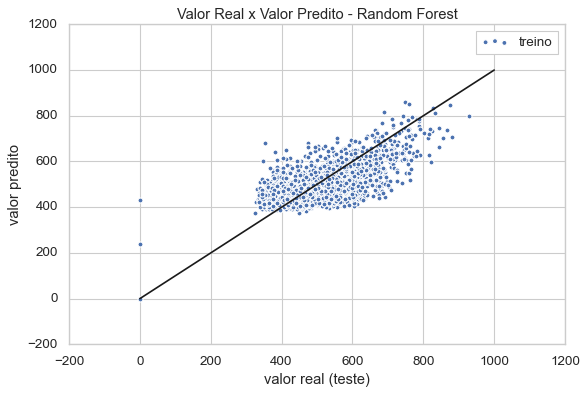

In [176]:
plt.scatter(y_test, y_pred, label='treino')
#plt.scatter(train_targets, train_predictions, label='train')

#plt.scatter(test_targets, test_predictions, label='test')
plt.plot(np.arange(0, 1000, 0.01), np.arange(0, 1000, 0.01), c='k')
plt.xlabel('valor real (teste)')
plt.ylabel('valor predito')
plt.title('Valor Real x Valor Predito - Random Forest')
plt.legend()
plt.show()

### XGBoost

In [167]:
from sklearn.ensemble import GradientBoostingRegressor

In [168]:
## XGB
# Import GradientBoostingRegressor

for nomeDf, dadosTreino in treinosDiciona.items():
    
    # dividindo treino e teste
    X = dadosTreino.drop('NU_NOTA_MT', axis=1)
    y = dadosTreino['NU_NOTA_MT']
    
    # 70% para treino
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Instantiate gb
    gb = GradientBoostingRegressor(max_depth=4,
                                   n_estimators=200,
                                   random_state=2)

    # Fit gb to the training set
    gb.fit(X_train, y_train)

    # Predict test set labels
    y_pred = gb.predict(X_test)

    # Compute MSE
    mse_test = MSE(y_test, y_pred)

    # Compute RMSE
    rmse_test = mse_test**(1/2)

    # Print RMSE
    print('base '+ nomeDf+'Teste RMSE do XBG: {:.3f}'.format(rmse_test))
    del gb


base baselineNAsTeste RMSE do XBG: 61.374
base knn5Teste RMSE do XBG: 64.614
base knn10Teste RMSE do XBG: 63.239


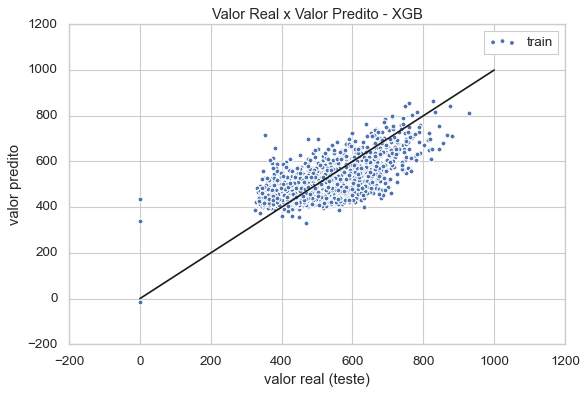

In [174]:
plt.scatter(y_test, y_pred, label='train')
#plt.scatter(train_targets, train_predictions, label='train')

#plt.scatter(test_targets, test_predictions, label='test')
plt.plot(np.arange(0, 1000, 0.01), np.arange(0, 1000, 0.01), c='k')
plt.xlabel('valor real (teste)')
plt.ylabel('valor predito')
plt.title('Valor Real x Valor Predito - XGB')
plt.legend()
plt.show()

In [205]:
dadosTreino = treinosDiciona['baselineNAs']
    # dividindo treino e teste
X = dadosTreino.drop('NU_NOTA_MT', axis=1)
y = dadosTreino['NU_NOTA_MT']
    
    # 70% para treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Instantiate gb
gb = GradientBoostingRegressor(max_depth=4,
                                   n_estimators=200,
                                   random_state=2)

    # Fit gb to the training set
gb.fit(X_train, y_train)

    # Predict test set labels
y_pred = gb.predict(X_test)

    # Compute MSE
mse_test = MSE(y_test, y_pred)

    # Compute RMSE
rmse_test = mse_test**(1/2)

    # Print RMSE
print('base '+ nomeDf+'Teste RMSE do XBG: {:.3f}'.format(rmse_test))

base knn10Teste RMSE do XBG: 61.374


In [207]:
testeSemNA = teste.fillna(-1)

y_pred = gb.predict(testeSemNA)

In [208]:
len(y_pred)

4576

In [210]:
testeOriginal = pd.read_csv('test.csv')

In [216]:
submeterDf = pd.DataFrame(
    data = {'NU_INSCRICAO': testeOriginal['NU_INSCRICAO'],
           'NU_NOTA_MT': y_pred
           })

In [217]:
submeterDf.head()

NU_INSCRICAO  NU_NOTA_MT
0  73ff9fcc02f0a99919906c942c2e1a1042cdcf98  441.620267
1  71a95f9f1b91a82c65ad94abbdf9f54e6066f968  442.927797
2  b38a03232f43b11c9d0788abaf060f7366053b6d  604.554206
3  70b682d9a3636be23f6120fa9d6b164eb3c6002d   -0.722206
4  715494628a50142ce8cb17191cfe6d0f3cae0934  572.875167

In [218]:
submeterDf.to_csv('answer.csv', index=False)

In [ ]:
d = {'col1': [1, 2], 'col2': [3, 4]}

df = pd.DataFrame(data=d)

## SVM (SVR - regressão)

In [178]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.utils import shuffle
import math

In [189]:
## XGB
# Import GradientBoostingRegressor

for nomeDf, dadosTreino in treinosDiciona.items():
    
    # dividindo treino e teste
    X = dadosTreino.drop('NU_NOTA_MT', axis=1)
    y = dadosTreino['NU_NOTA_MT']
    
    # 70% para treino
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Instantiate SVM
    svm = SVR()

    # Fit gb to the training set
    svm.fit(X_train, y_train)

    # Predict test set labels
    y_pred = svm.predict(X_test)

    # Compute MSE
    mse_test = MSE(y_test, y_pred)

    # Compute RMSE
    rmse_test = mse_test**(1/2)

    # Print RMSE
    print('base '+ nomeDf+'Teste RMSE do SVM: {:.3f}'.format(rmse_test))
    del svm


base baselineNAsTeste RMSE do SVM: 78.094
base knn5Teste RMSE do SVM: 72.496
base knn10Teste RMSE do SVM: 71.207


No código abaixo não é necessário separar treino e teste pois ele já faz a validação cruzada.

E também já está fazendo o ajuste dos hiperparâmetros.

In [184]:
def svr_model(X, y):
    gsc = GridSearchCV(
        estimator=SVR(kernel='linear'),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_best_svr = SVR(kernel='linear', C=best_params["C"], epsilon=best_params["epsilon"], coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)

    scoring = {'abs_error': 'neg_mean_absolute_error',
               'squared_error': 'neg_mean_squared_error'}
    
    scores = cross_validate(best_svr, X, y, cv=10, scoring=scoring, return_train_score=True)
    
    return "MAE :", abs(scores['test_abs_error'].mean()), "| RMSE :", math.sqrt(abs(scores['test_squared_error'].mean()))

## Ajuste dos hiperparametros

In [192]:
from sklearn.metrics import mean_squared_error as MSE

## Random Forest

In [199]:
dadosTreino = treinosDiciona['baselineNAs']

X = dadosTreino.drop('NU_NOTA_MT', axis=1)
y = dadosTreino['NU_NOTA_MT']

grid_param = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_features':  list(range(1,X.shape[1])),
    'max_depth':   np.linspace(1, 32, 32, endpoint=True),
    'min_samples_split':  np.linspace(0.1, 1.0, 10, endpoint=True),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True)
}

from sklearn.model_selection import RandomizedSearchCV

RF = RandomForestRegressor(random_state=1)

RF_random = RandomizedSearchCV(
    estimator = RF,
	param_distributions = grid_param, n_iter = 500,
	cv = 5, verbose=2, random_state=42,
	n_jobs = -1)

RF_random.fit(X, y)

print(RF_random.best_params_)



Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  8.3min finished


{'n_estimators': 100, 'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_features': 82, 'max_depth': 21.0}


In [201]:
RF_random.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=21.0, max_features=82, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.1,
                      min_samples_split=0.2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [202]:
for nomeDf, dadosTreino in treinosDiciona.items():
    
    # dividindo treino e teste
    X = dadosTreino.drop('NU_NOTA_MT', axis=1)
    y = dadosTreino['NU_NOTA_MT']
    
    # 70% para treino
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create a Random Forest Classifier with specified criterion
    rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=21.0, max_features=82, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.1,
                      min_samples_split=0.2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

    # Fit rf to the training set            
    rf.fit(X_train, y_train)                           

    # Predict the test set labels
    y_pred = rf.predict(X_test)

    # Evaluate the test set RMSE
    rmse_test = MSE(y_test, y_pred)**(1/2)

    # Print rmse_test
    print('base '+ nomeDf+' Teste RMSE do RF: {:.2f}'.format(rmse_test))
    
    del rf

base baselineNAs Teste RMSE do RF: 68.28
base knn5 Teste RMSE do RF: 71.35
base knn10 Teste RMSE do RF: 70.46


In [193]:
for nomeDf, dadosTreino in treinosDiciona.items():
    
    # dividindo treino e teste
    X = dadosTreino.drop('NU_NOTA_MT', axis=1)
    y = dadosTreino['NU_NOTA_MT']
    
    # 70% para treino
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Instantiate rf
    rf = RandomForestRegressor(n_estimators=25,
                               random_state=2)

    # Fit rf to the training set            
    rf.fit(X_train, y_train)                           

    # o modelo já foi treinado !!!

    # ajuste hiperparametrso regressosr
    # Define the dictionary 'params_rf'
    params_rf = {
                 'n_estimators': [100, 350, 500],
                 'max_features': ['log2', 'auto', 'sqrt'],
                 'min_samples_leaf': [2, 10, 30], 
                 }

    # Instantiate grid_rf
    grid_rf = GridSearchCV(estimator=rf,
                           param_grid=params_rf,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

    # Extract the best estimator
    best_model = grid_rf.best_estimator_

    # Predict test set labels
    y_pred = best_model.predict(X_test)

    # Compute rmse_test
    rmse_test = MSE(y_test, y_pred)**(1/2)

    # Print rmse_test
    print('base '+chave+' - Teste RMSE do melhor modelo RF: {:.3f}'.format(rmse_test)) 

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
 GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [2, 4, 8, 15], 'max_features': ['auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0) 

## XGB

In [204]:
import xgb

ModuleNotFoundError: No module named 'xgb'

In [203]:
dadosTreino = treinosDiciona['baselineNAs']
# dividindo treino e teste
X = dadosTreino.drop('NU_NOTA_MT', axis=1)
y = dadosTreino['NU_NOTA_MT']
    
# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.7, random_state=123)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective="reg:linear", n_estimators=10, seed=123)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

NameError: name 'xgb' is not defined

In [ ]:
 GridSearchCV(cv=7, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'number_attempts': [2, 4, 6], 'max_depth': [3, 6, 9, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [186]:
# Run 
for nomeDf, dadosTreino in treinosDiciona.items():
    
    if nomeDf != 'baselineNAs':
        # dividindo treino e teste
        X = dadosTreino.drop('NU_NOTA_MT', axis=1)
        y = dadosTreino['NU_NOTA_MT']

        print(nomeDf)
        print(svr_model(X,y))
        print()

knn5


KeyboardInterrupt: 

In [129]:
print(teste.shape)

(4576, 146)


In [114]:
treino['TP_STATUS_REDACAO_1.0'].value_counts()

1.0    9892
0.0     241
Name: TP_STATUS_REDACAO_1.0, dtype: int64

In [ ]:
aux = teste.copy()

In [ ]:
aux.head()

In [ ]:
aux = corrigeDummies(aux, colsTeste['categNom'])

In [ ]:
aux.shape

In [ ]:
aux.head()

In [ ]:
list(aux.columns)

In [ ]:
list(teste.columns)

In [ ]:
treino.tail(25)

In [ ]:
aux.tail(25)

In [ ]:
dummies = pd.get_dummies('TP_DEPENDENCIA_ADM_ESC' + '_' + treino['TP_DEPENDENCIA_ADM_ESC'].astype(str))

In [ ]:
dummies

In [ ]:
'nan' in ('_'.join(list(dummies.columns)))

In [ ]:
for col in list(dummies.columns):
    if 'nan' in col:
        colNan = col

In [ ]:
colNan

In [ ]:
dummies[dummies[colNan].astype(bool)] = np.nan

In [ ]:
dummies.drop(col, axis=1, inplace=True)

In [ ]:
dummies.head(50)

# Manuseando os Missings

In [ ]:
numCont

In [ ]:
cols = [numCont, numDisc, categOrd]
cols = np.hstack(cols)
cols = list(cols)

### Preenchendo missings com média

In [ ]:
# copiando dados
treino_media = treino[cols].copy(deep=True)

# criando objeto para imputar media (modelo sklearn)
mediaImputar = SimpleImputer(strategy='mean')

# insere os dados
treino_media.iloc[:, :] = mediaImputar.fit_transform(treino_media)

# PODERIA FAZER DA SEGUINTE FORMA 
# aplicar o modelo pra preencher os missings do TESTE

# treino_media = treino[cols].copy(deep=True)
# mediaImputar = SimpleImputer(strategy='mean')
# mediaImputar.fit(treino_media)
# treino_media = auxImput.transform(treino_media)

In [ ]:
treino_media.head()

In [ ]:
treino_media.describe()

### Preenchendo missings com mediana

In [ ]:
treino_mediana = treino[cols].copy(deep=True)

# Create median imputer object
medianaInsere = SimpleImputer(strategy='median')

# Impute median values in the DataFrame diabetes_median
treino_mediana.iloc[:, :] = medianaInsere.fit_transform(treino_mediana)

In [ ]:
treino_mediana.head()

In [ ]:
treino_mediana.describe()

### Preenchendo com a moda

In [ ]:
# Make a copy of diabetes
treino_moda = treino[cols].copy(deep=True)

# Create mode imputer object
mode_imputer = SimpleImputer(strategy="most_frequent")

# Impute using most frequent value in the DataFrame mode_imputer
treino_moda.iloc[:, :] = mode_imputer.fit_transform(treino_moda)

In [ ]:
treino_moda.describe()

### Preenche missings com uma constante

In [ ]:
# Make a copy of diabetes
treino_cte = treino[cols].copy(deep=True)

# Create median imputer object
constant_imputer = SimpleImputer(strategy="constant", fill_value=0)

# Impute missing values to 0 in diabetes_constant
treino_cte.iloc[:, :] = constant_imputer.fit_transform(treino_cte)

### Visualizando valores inseridos

In [ ]:
plt.style.use('classic')

# Set nrows and ncols to 2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
nullity = treino.NU_NOTA_MT.isnull()+treino.NU_NOTA_CN.isnull()

# Create a dictionary of imputations
imputations = {'Mean Imputation': treino_media, 'Median Imputation': treino_mediana, 
               'Most Frequent Imputation': treino_moda, 'Constant Imputation': treino_cte}

# Loop over flattened axes and imputations
for ax, df_key in zip(axes.flatten(), imputations):
    # Select and also set the title for a DataFrame
    imputations[df_key].plot(x='NU_NOTA_MT', y='NU_NOTA_CN', kind='scatter', 
                          alpha=0.5, c=nullity, cmap='rainbow', ax=ax, 
                          colorbar=False, title=df_key)
plt.show()

### Visualização / Análise das imputações

Visualização usada para definir qual melhor dos preenchimentos dos valores ausentes. 

Acima observamos como essas imputações são retratadas como uma linha reta e não se ajustam à forma dos dados!

A media e a mediana ficaram próximas, mas ainda assim não acompanham o crescimento linear das variáveis, já que elas possuem uma correlação positiva.


### KNN (vizinhos) para prencher os missings

O **fancyimputepacote** oferece vários modelos robustos de aprendizado de máquina para imputar valores ausentes. 

Vale a pena testar outros na documentação.

In [ ]:
# para instalar fancyimpute no windows 10 é necessario baixar alguns packages
# intermediarios (ecos e scs em amd64) no repositorio python pra windowns (https://www.lfd.uci.edu/~gohlke/pythonlibs/)
# ir até o local dos arquivos e pip install file.whl

# from fancyimpute import KNN

# Copy diabetes to diabetes_knn_imputed
treino_knn_imputed = treino[cols].copy(deep=True)

# Initialize KNN
knn_imputer = KNN()

# Impute using fit_tranform on diabetes_knn_imputed
treino_knn_imputed.iloc[:, :] = knn_imputer.fit_transform(treino_knn_imputed)

In [ ]:
treino_knn_imputed.describe()

### Testando *IterativeImputer*

 *IterativeImputer* várias regressões em amostras aleatórias dos dados e agregados para imputar os valores ausentes.

In [ ]:
# Import IterativeImputer from fancyimpute
#from fancyimpute import IterativeImputer

# Copy diabetes to diabetes_mice_imputed
treino_mice_imputed = treino[cols].copy(deep=True)

# Initialize IterativeImputer
mice_imputer = IterativeImputer()

# Impute using fit_tranform on diabetes
treino_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(treino[cols])

### Codificação ordinal de uma coluna categórica

Com a função *OrdinalEncoder* eu consigo passar numéricas as colunas categóricas, por exemplo {SP, MG, RJ...} se torna {1, 2, 3...}

Contudo, variáveis categóricas ordinais (respeitam um **ORDEM**) deve ser convertidas manualmente ou com auxílio de um dicionário de dados para ordem ser preservada.

Exe: *{'frio':1, 'morno':2, 'quente':3}*

Caso o *OrdinalEncoder* seja aplicado numa variável categórica ordinal, ele irá atribuir a ordem dos fatores de acordo com a ordem alfabética, o que poderá ser uma informação **INCORRETA** caso não seja a ordem correta.

In [ ]:
# aplica conversao da coluna categorica ESTADO
# ordenando por ordem alfabetica 
# ERRADO conceitualmente por ser uma Dummy
treinoAux = treino.copy(deep=True)
# Create Ordinal encoder
racaEncodOrdin = OrdinalEncoder()

# tirand os valores nulos da raça
raca = treino['SG_UF_RESIDENCIA']
raca_not_null = raca[raca.notnull()]

# transformando em um vetor
reshaped_vals = raca_not_null.values.reshape(-1, 1)

# Ordinally encode reshaped_vals
encoded_vals = racaEncodOrdin.fit_transform(reshaped_vals)

# Assign back encoded values to non-null values of ambience in users
treinoAux.loc[raca.notnull(), 'SG_UF_RESIDENCIA'] = np.squeeze(encoded_vals)

In [ ]:
treinoAux.tail()

In [ ]:
# no loop abaixo aplico OrdinalEncoder em todas 
# colunas do dataframe

# Create an empty dictionary ordinal_enc_dict
# ordinal_enc_dict = {}

# for col_name in users:
#     # Create Ordinal encoder for col
#     ordinal_enc_dict[col_name] = OrdinalEncoder()
#     col = users[col_name]
    
#     # Select non-null values of col
#     col_not_null = col[col.notnull()]
#     reshaped_vals = col_not_null.values.reshape(-1, 1)
#     encoded_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    
#     # Store the values to non-null values of the column in users
#     users.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)

### Avaliando o melhor preechimento dos missings

Realizo uma regressão linear e vejo qual se adequa melhor aos dados (maior R^2)

In [ ]:
aux = treino[cols].copy()
aux.dropna(inplace=True)

# Add constant to X and set X & y values to fit linear model
X = sm.add_constant(aux.drop(['NU_NOTA_MT'], axis=1))
y = aux['NU_NOTA_MT']
lm = sm.OLS(y, X).fit()

# Print R squared score of lm
print('\nAdjusted R-squared score: ', lm.rsquared_adj)

In [ ]:
X = sm.add_constant(treino_media.drop(['NU_NOTA_MT'], axis=1))
y = treino_media['NU_NOTA_MT']
lm_media = sm.OLS(y, X).fit()

X = sm.add_constant(treino_knn_imputed.drop(['NU_NOTA_MT'], axis=1))
y = treino_knn_imputed['NU_NOTA_MT']
lm_knn = sm.OLS(y, X).fit()

X = sm.add_constant(treino_mice_imputed.drop(['NU_NOTA_MT'], axis=1))
y = treino_mice_imputed['NU_NOTA_MT']
lm_mice = sm.OLS(y, X).fit()



In [ ]:
# Store the Adj. R-squared scores of the linear models
r_squared = pd.DataFrame({'NAs removidos': lm.rsquared_adj, 
                          'Mean Imputation': lm_media.rsquared_adj, 
                          'KNN Imputation': lm_knn.rsquared_adj, 
                          'MICE Imputation': lm_mice.rsquared_adj}, 
                         index=['Adj. R-squared'])

print(r_squared)

O que tiver o maior R^2 acima é a melhor opção.

In [ ]:
r_squares = {'Mean Imputation': lm_media.rsquared_adj, 
             'KNN Imputation': lm_knn.rsquared_adj, 
             'MICE Imputation': lm_mice.rsquared_adj}

# Select best R-squared
best_imputation = max(r_squares, key=r_squares.get)

print("A mehlor técnica de inserção de missings é: ", best_imputation)

### Visualizando melhor preenchimento

In [ ]:
# Plot graphs of imputed DataFrames and the complete case
aux['NU_NOTA_MT'].plot(kind='kde', c='red', linewidth=3)
treino_media['NU_NOTA_MT'].plot(kind='kde')
treino_knn_imputed['NU_NOTA_MT'].plot(kind='kde')
treino_mice_imputed['NU_NOTA_MT'].plot(kind='kde')

# Create labels for the four DataFrames
labels = ['Baseline (NA removidos)', 'Mean Imputation', 'KNN Imputation', 'MICE Imputation']
plt.legend(labels)

# Set the x-label as Skin Fold
plt.xlabel('NU_NOTA_MT')

plt.show()

Acima vemos que o KNN pode ser a melhor opção do que o MICE pois o MICE se aproxima muito da média, apesar deste ter apresentado um R^2 superior.

In [ ]:
treino.head()

# Pré-processamento dos dados

Engenharia de variáveis e escalonamento dos dados, além de outras técnicas.

## Padronização dos dados

Extramente importante ao se utilizar um modelo linear.

In [ ]:
# Import StandardScaler from scikit-learn
# from sklearn.preprocessing import StandardScaler

# (x - media) / desvioPadrao
ss = StandardScaler()

# Take a subset of the DataFrame you want to scale 
treinoNormalizado = treino[cols].copy()

# Apply the scaler to the DataFrame subset
treinoNormalizado = ss.fit_transform(treinoNormalizado)

In [ ]:
treino.drop(cols, axis=1).head()

In [ ]:
estados = pd.get_dummies(treino['SG_UF_RESIDENCIA'])

In [ ]:
estados.head()

In [ ]:
racas = pd.get_dummies('raca'+treino['TP_COR_RACA'].astype(str))

In [ ]:
racas.head()

In [ ]:
estados = pd.get_dummies(treino['SG_UF_RESIDENCIA'])
racas = pd.get_dummies('raca'+treino['TP_COR_RACA'].astype(str))

### Redução de dimensionalidade

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# from sklearn.decomposition import PCA

# Set up PCA and the X vector for diminsionality reduction
pca = PCA()
dfReduzir = treino[cols].copy().dropna()

# Apply PCA to the wine dataset
dfTransformed = pca.fit_transform(dfReduzir)

# Look at the percentage of variance explained by the different components
print(pca.explained_variance_ratio_)

In [ ]:
# FLUXO BÁSICA DA CIÊNCIA DE DADOS

# from sklearn import neighbors, datasets, preprocessing
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# iris = datasets.load_iris()
# X, y = iris.data[:, :2], iris.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# knn = neighbors.KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)
# accuracy_score(y_test, y_pred)

In [ ]:
# IMPUTANDO MISSINGS de SÉRIES TEMPORAIS

# nesse banco de dados todas variaveis são continuas

# Print prior to imputing missing values
print(airquality[30:40])

# Fill NaNs using forward fill
airquality.fillna(method='ffill', inplace=True)

# Print after imputing missing values
print(airquality[30:40])

# Print prior to imputing missing values
print(airquality[30:40])

# Fill NaNs using backward fill
airquality.fillna(method='bfill', inplace=True)

# Print after imputing missing values
print(airquality[30:40])

#####################

# INTERPOLAÇÃO

# Print prior to interpolation
print(airquality[30:40])

# Interpolate the NaNs linearly
airquality.interpolate(method='linear', inplace=True)

# Print after interpolation
print(airquality[30:40])

### INTERPOLAÇÃO QUADRATICA

# Print prior to interpolation
print(airquality[30:40])

# Interpolate the NaNs quadratically
airquality.interpolate(method='quadratic', inplace=True)

# Print after interpolation
print(airquality[30:40])

### COM DADOS PROXIMOS

# Print prior to interpolation
print(airquality[30:40])

# Interpolate the NaNs with nearest value
airquality.interpolate(method='nearest', inplace=True)

# Print after interpolation
print(airquality[30:40])

###################

# Impute airquality DataFrame with ffill method
ffill_imputed = airquality.fillna(method='ffill')

# Impute airquality DataFrame with ffill method
ffill_imputed = airquality.fillna(method='ffill')

# Plot the imputed DataFrame ffill_imp in red dotted style 
ffill_imputed['Ozone'].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))

plt.show()

# Impute airquality DataFrame with ffill method
ffill_imputed = airquality.fillna(method='ffill')

# Plot the imputed DataFrame ffill_imp in red dotted style 
ffill_imputed['Ozone'].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))

# Plot the airquality DataFrame with title
airquality['Ozone'].plot(title='Ozone', marker='o', figsize=(30, 5))

plt.show()

######################

# VISUALIZADANDO backward

# Impute airquality DataFrame with bfill method
bfill_imputed = airquality.fillna(method='bfill')

# Impute airquality DataFrame with bfill method
bfill_imputed = airquality.fillna(method='bfill')

# Plot the imputed DataFrame bfill_imp in red dotted style 
bfill_imputed['Ozone'].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))

plt.show()

# Impute airquality DataFrame with bfill method
bfill_imputed = airquality.fillna(method='bfill')

# Plot the imputed DataFrame bfill_imp in red dotted style 
bfill_imputed['Ozone'].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))

# Plot the airquality DataFrame with title
airquality['Ozone'].plot(title='Ozone', marker='o', figsize=(30, 5))

plt.show()

###############################
# PLOTANDO INTERPOLACAO

# Set nrows to 3 and ncols to 1
fig, axes = plt.subplots(3, 1, figsize=(30, 20))

# Create a dictionary of interpolations
interpolations = {'Linear Interpolation': linear, 'Quadratic Interpolation': quadratic, 
                  'Nearest Interpolation': nearest}

# Loop over axes and interpolations
for ax, df_key in zip(axes, interpolations):
  # Select and also set the title for a DataFrame
  interpolations[df_key].Ozone.plot(color='red', marker='o', 
                                 linestyle='dotted', ax=ax)
  airquality.Ozone.plot(title=df_key + ' - Ozone', marker='o', ax=ax)
  
plt.show()



In [ ]:
treino[categNom].head()

In [ ]:
# converte coluna para numerica
# tips['tip'] = pd.to_numeric(tips['tip'], errors='coerce')

In [ ]:
# limpando os valores das colunas
# Define recode_gender()
def recode_gender(gender):

    # Return 0 if gender is 'Female'
    if gender == 'Female':
        return 0
    
    # Return 1 if gender is 'Male'
    elif gender == 'Male':
        return 1
        
    # Return np.nan    
    else:
        return np.nan

# Apply the function to the sex column
tips['recode'] = tips.sex.apply(recode_gender)

# aplica trasnformação na coluna
tips['total_dollar_replace'] = tips.total_dollar.apply(lambda x: x.replace('$', ''))

# remove linhas duplicadas
tracks_no_duplicates = tracks.drop_duplicates()

# Print the first five rows of tips
print(tips.head())


In [ ]:
# alterando valores dos dados
# Set all values above 27 to 27
ride_sharing.loc[ride_sharing['tire_sizes'] > 27, 'tire_sizes'] = 27

# remove espaços no começo, no fim e coloca em minusculas as letras
airlines['dest_size'] = airlines['dest_size'].str.lstrip().str.rstrip().str.lower()

In [ ]:
# transformando variáveis de intervalo em numericas 
# assim o modelo pode funcionar melhor
# Create ranges for categories
label_ranges = [0, 60, 180, np.inf]
label_names = ['short', 'medium', 'long']

# Create wait_type column
airlines['wait_type'] = pd.cut(airlines['wait_min'], bins = label_ranges, 
                               labels = label_names)

# Create mappings and replace
mappings = {'Monday':'weekday', 'Tuesday':'weekday', 'Wednesday': 'weekday', 
            'Thursday': 'weekday', 'Friday': 'weekday', 
            'Saturday': 'weekend', 'Sunday': 'weekend'}

airlines['day_week'] = airlines['day'].replace(mappings)

assert gapminder.country.dtypes == np.object

# Test if year is of type int64
assert gapminder.year.dtypes == np.int64

# Test if life_expectancy is of type float64
assert gapminder.life_expectancy.dtypes == np.float64

In [ ]:
mappings = {'Monday':'weekday', 'Tuesday':'weekday', 'Wednesday': 'weekday', 
            'Thursday': 'weekday', 'Friday': 'weekday', 
            'Saturday': 'weekend', 'Sunday': 'weekend'}

In [ ]:
letras = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,
          'I':9,'J':10,'K':11,'L':12,'M':13,'N':14,'O':15,'P':16,'Q':17}

In [ ]:
list(letras.keys())

In [ ]:
'aba' in ['c', 'e', 'aba']

# Manuseando missings

# Modelos: árvores de decisão

In [ ]:
# o dataset possui colunas numericas continuas e 
# colunas categoriacas nominais quebradas em one hot encoding SEM NULOS

# árvore para regressao simples
# Instantiate dt
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=8,
                           min_samples_leaf=0.13,
                           random_state=3)

# Fit dt to the training set
dt.fit(X_train, y_train)

# mas essa já suporta coluna numéricas inteiras (idade), as colunas nominais
# devem ser quebradas em one-hot-encodings na mão

In [ ]:
# prevendo e analisando o erro
# raiz quadrada do Erro Quadrático Médio (MSE) do modelo.

# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

In [ ]:
# o modelo abaixo suporta variáveis continuas, inteiras e binarias (uma unica coluna)
# mas todas colunas sao numericas SEM NULOS

# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Set SEED for reproducibility
SEED = 1

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# Instantiate a DecisionTreeRegressor dt
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.26, random_state=SEED)

In [ ]:
# Validacao cruzada, se retornar erro negativo deve ser multiplicado
# por -1 SEM NULOS

# dados tambem com colunas numerica, binarias unicas (0 1, uma única coluna) SEM NULOS

# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

# AVALIANDO O ERRO DO MODELO ACIMA com validacao cruzada

# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict the labels of the training set
y_pred_train = dt.predict(X_train)

# Evaluate the training set RMSE of dt
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

 posso avaliar o modelo com CV e sem CV para diagnosticar os problemas de desvio e variação de dt, você pode comparar RMSE_traincom RMSE_CV.

In [ ]:
# REGRESSÃO
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,
                           random_state=2)
                           
# Fit rf to the training set            
rf.fit(X_train, y_train)                           

# avaliando RMSE 
# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

### Importância das variáveis

In [ ]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [ ]:
## XGB
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4,
                               n_estimators=200,
                               random_state=2)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred = gb.predict(X_test)

# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute MSE
mse_test = MSE(y_test, y_pred)

# Compute RMSE
rmse_test = mse_test**(1/2)

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

In [ ]:
# XGB com aumento estocástico do gradiente
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate sgbr
sgbr = GradientBoostingRegressor(max_depth=4, 
                                 subsample=0.9,
                                 max_features=0.75,
                                 n_estimators=200,                                
                                 random_state=2)

# Fit sgbr to the training set
sgbr.fit(X_train, y_train)

# Predict test set labels
y_pred = sgbr.predict(X_test)

# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute test set MSE
mse_test = MSE(y_test, y_pred)

# Compute test set RMSE
rmse_test = mse_test**(1/2)

# Print rmse_test
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test))

### Ajuste dos hiperparametros

In [ ]:
# Define params_dt
params_dt = {
             'max_depth': [2, 3, 4],
             'min_samples_leaf': [0.12, 0.14, 0.16, 0.18]
            }

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Instantiate grid_dt
# dt é o modelo scikit_learn
# sklearn.tree.tree.DecisionTreeRegressor
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='roc_auc',
                       cv=5,
                       n_jobs=-1)

# Import roc_auc_score from sklearn.metrics 
from sklearn.metrics import roc_auc_score

# Extract the best estimator
best_model = grid_dt.best_estimator_

# Predict the test set probabilities of the positive class
y_pred_proba = best_model.predict_proba(X_test)[:,1]

# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print test_roc_auc
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))

In [ ]:
# sklearn.ensemble.forest.RandomForestRegressor

# o modelo já foi treinado !!!

# ajuste hiperparametrso regressosr
# Define the dictionary 'params_rf'
params_rf = {
             'n_estimators': [100, 350, 500],
             'max_features': ['log2', 'auto', 'sqrt'],
             'min_samples_leaf': [2, 10, 30], 
             }

# Import GridSearchCV
from sklearn.model_selection import  GridSearchCV

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

# Import mean_squared_error from sklearn.metrics as MSE 
from sklearn.metrics import mean_squared_error as MSE

# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

# Pré-processamento dos dados

In [ ]:
treino.columns

In [ ]:
list(enem.columns)
colsRemover = [
    'NU_INSCRICAO',
    'NU_ANO',
    'NO_MUNICIPIO_RESIDENCIA',
    'SG_UF_RESIDENCIA',
    'NO_MUNICIPIO_NASCIMENTO',
    'SG_UF_NASCIMENTO',
    'CO_ESCOLA',
    'CO_MUNICIPIO_ESC',
    'NO_MUNICIPIO_ESC',
    'CO_UF_ESC',
    'SG_UF_ESC',
    'NO_ENTIDADE_CERTIFICACAO',
    'NO_MUNICIPIO_PROVA',
    'SG_UF_PROVA',
    
    
]